<a href="https://colab.research.google.com/github/NilBeserler/COGS181_FinalProject/blob/main/Model_and_Training_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#!pip install keras scikit-learn imbalanced-learn

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



In [ ]:
# LFW dataset loading 
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))
X = lfw_people.images
y = lfw_people.target

# Normalization and transorming
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
X = torch.stack([transform(img) for img in X])
y = torch.tensor(y)

# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


# Data Loader
train_dataset = TensorDataset(train_X, train_y)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_X, test_y)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



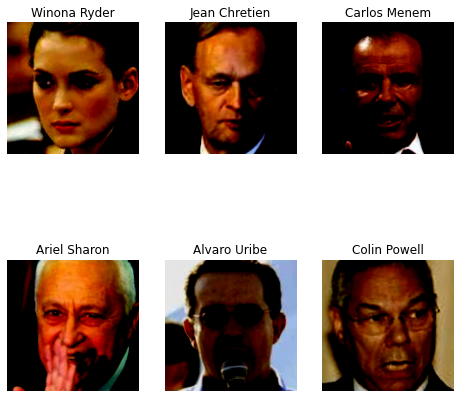

In [ ]:
#Printing 6 images
target_names = lfw_people.target_names
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for i in range(6):
    ax = axs[i // 3, i % 3]
    ax.imshow(X[i].permute(1, 2, 0))
    ax.set_title(target_names[y[i]])
    ax.axis('off')
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cpu


In [ ]:
n_classes = len(np.unique(test_y))
print('Number of classes:', n_classes)


Number of classes: 62


In [ ]:

# 3 layer CNN arch
"""
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 19 * 19, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 62)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 19 * 19)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

net = Net()
net.to(device)

"""

'\nimport torch.nn as nn\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)\n        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)\n        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.fc1 = nn.Linear(64 * 19 * 19, 512)\n        self.dropout = nn.Dropout(0.5)\n        self.fc2 = nn.Linear(512, 62)\n\n    def forward(self, x):\n        x = self.pool(nn.functional.relu(self.conv1(x)))\n        x = self.pool(nn.functional.relu(self.conv2(x)))\n        x = self.pool(nn.functional.relu(self.conv3(x)))\n        x = x.view(-1, 64 * 19 * 19)\n        x = nn.functional.relu(self.fc1(x))\n        x = self.dropout(x)\n        x = self.fc2(x)\n\n        return x\n\nnet = Net()\nnet.to(device)\n\n'

In [ ]:
""
#Training for normal CNN
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# loss function.
loss_func = nn.CrossEntropyLoss()

# optimizer.
#opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#opt = optim.Adadelta(net.parameters(), lr=0.001, rho=0.9, eps=1e-06)
#opt = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-6)


avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # progress bar
    for i, data in enumerate(pbar):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        pbar.set_postfix({"Avg Loss": f"{running_loss / (i+1):.3f}"}) # Updateprogress bar
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

# Plot loss graph.
plt.figure()
plt.plot(avg_losses)
plt.title('Average Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

"""


'\n#Training for normal CNN\nimport torch.nn as nn\nimport torch.optim as optim\nfrom tqdm import tqdm\nimport matplotlib.pyplot as plt\n\n# Define the loss function.\nloss_func = nn.CrossEntropyLoss()\n\n# Define the optimizer.\n#opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)\nopt = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)\n#opt = optim.Adadelta(net.parameters(), lr=0.001, rho=0.9, eps=1e-06)\n#opt = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-6)\n\n\navg_losses = []   # Avg. losses.\nepochs = 10       # Total epochs.\nprint_freq = 1  # Print frequency.\n\nfor epoch in range(epochs):  # Loop over the dataset multiple times.\n    running_loss = 0.0       # Initialize running loss.\n    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # Create a progress bar\n    for i, data in enumerate(pbar):\n        # Get the inputs.\n        inputs, labels = data\n        \n        # Move the inputs to the specified 

In [ ]:

import torchvision.models as models

# ResNet18.
net = models.resnet18(pretrained=True)

# last layer modified
num_classes = len(torch.unique(y))
net.fc = nn.Linear(net.fc.in_features, num_classes)




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0:   1%|▏         | 1/76 [00:07<09:26,  7.55s/it, Avg Loss=4.413]

[epoch: 0, i:     0] avg mini-batch loss: 4.413


Epoch 0:   3%|▎         | 2/76 [00:12<07:46,  6.31s/it, Avg Loss=2.126]

[epoch: 0, i:     1] avg mini-batch loss: 4.252


Epoch 0:   4%|▍         | 3/76 [00:17<06:56,  5.70s/it, Avg Loss=1.391]

[epoch: 0, i:     2] avg mini-batch loss: 4.172


Epoch 0:   5%|▌         | 4/76 [00:21<05:54,  4.93s/it, Avg Loss=1.062]

[epoch: 0, i:     3] avg mini-batch loss: 4.250


Epoch 0:   7%|▋         | 5/76 [00:25<05:23,  4.56s/it, Avg Loss=0.837]

[epoch: 0, i:     4] avg mini-batch loss: 4.185


Epoch 0:   8%|▊         | 6/76 [00:30<05:33,  4.77s/it, Avg Loss=0.675]

[epoch: 0, i:     5] avg mini-batch loss: 4.051


Epoch 0:   9%|▉         | 7/76 [00:34<05:06,  4.44s/it, Avg Loss=0.635]

[epoch: 0, i:     6] avg mini-batch loss: 4.443


Epoch 0:  11%|█         | 8/76 [00:38<04:43,  4.16s/it, Avg Loss=0.506]

[epoch: 0, i:     7] avg mini-batch loss: 4.051


Epoch 0:  12%|█▏        | 9/76 [00:43<05:03,  4.52s/it, Avg Loss=0.408]

[epoch: 0, i:     8] avg mini-batch loss: 3.672


Epoch 0:  13%|█▎        | 10/76 [00:47<04:40,  4.25s/it, Avg Loss=0.365]

[epoch: 0, i:     9] avg mini-batch loss: 3.647


Epoch 0:  14%|█▍        | 11/76 [00:50<04:24,  4.07s/it, Avg Loss=0.356]

[epoch: 0, i:    10] avg mini-batch loss: 3.911


Epoch 0:  16%|█▌        | 12/76 [00:55<04:26,  4.17s/it, Avg Loss=0.334]

[epoch: 0, i:    11] avg mini-batch loss: 4.014


Epoch 0:  17%|█▋        | 13/76 [00:59<04:28,  4.27s/it, Avg Loss=0.259]

[epoch: 0, i:    12] avg mini-batch loss: 3.365


Epoch 0:  18%|█▊        | 14/76 [01:03<04:15,  4.12s/it, Avg Loss=0.254]

[epoch: 0, i:    13] avg mini-batch loss: 3.561


Epoch 0:  20%|█▉        | 15/76 [01:07<04:06,  4.05s/it, Avg Loss=0.226]

[epoch: 0, i:    14] avg mini-batch loss: 3.383


Epoch 0:  21%|██        | 16/76 [01:12<04:22,  4.37s/it, Avg Loss=0.226]

[epoch: 0, i:    15] avg mini-batch loss: 3.620


Epoch 0:  22%|██▏       | 17/76 [01:16<04:17,  4.36s/it, Avg Loss=0.214]

[epoch: 0, i:    16] avg mini-batch loss: 3.643


Epoch 0:  24%|██▎       | 18/76 [01:20<04:03,  4.19s/it, Avg Loss=0.204]

[epoch: 0, i:    17] avg mini-batch loss: 3.674


Epoch 0:  25%|██▌       | 19/76 [01:25<04:15,  4.49s/it, Avg Loss=0.179]

[epoch: 0, i:    18] avg mini-batch loss: 3.405


Epoch 0:  26%|██▋       | 20/76 [01:29<03:57,  4.23s/it, Avg Loss=0.187]

[epoch: 0, i:    19] avg mini-batch loss: 3.738


Epoch 0:  28%|██▊       | 21/76 [01:35<04:27,  4.87s/it, Avg Loss=0.172]

[epoch: 0, i:    20] avg mini-batch loss: 3.622


Epoch 0:  29%|██▉       | 22/76 [01:40<04:18,  4.79s/it, Avg Loss=0.152]

[epoch: 0, i:    21] avg mini-batch loss: 3.341


Epoch 0:  30%|███       | 23/76 [01:44<03:56,  4.46s/it, Avg Loss=0.161]

[epoch: 0, i:    22] avg mini-batch loss: 3.714


Epoch 0:  32%|███▏      | 24/76 [01:48<03:45,  4.33s/it, Avg Loss=0.148]

[epoch: 0, i:    23] avg mini-batch loss: 3.560


Epoch 0:  33%|███▎      | 25/76 [01:53<03:54,  4.59s/it, Avg Loss=0.123]

[epoch: 0, i:    24] avg mini-batch loss: 3.070


Epoch 0:  34%|███▍      | 26/76 [01:57<03:39,  4.39s/it, Avg Loss=0.130]

[epoch: 0, i:    25] avg mini-batch loss: 3.382


Epoch 0:  36%|███▌      | 27/76 [02:00<03:26,  4.22s/it, Avg Loss=0.140]

[epoch: 0, i:    26] avg mini-batch loss: 3.770


Epoch 0:  37%|███▋      | 28/76 [02:06<03:35,  4.49s/it, Avg Loss=0.122]

[epoch: 0, i:    27] avg mini-batch loss: 3.418


Epoch 0:  38%|███▊      | 29/76 [02:09<03:19,  4.25s/it, Avg Loss=0.125]

[epoch: 0, i:    28] avg mini-batch loss: 3.639


Epoch 0:  39%|███▉      | 30/76 [02:13<03:09,  4.12s/it, Avg Loss=0.107]

[epoch: 0, i:    29] avg mini-batch loss: 3.223


Epoch 0:  41%|████      | 31/76 [02:18<03:19,  4.43s/it, Avg Loss=0.098]

[epoch: 0, i:    30] avg mini-batch loss: 3.023


Epoch 0:  42%|████▏     | 32/76 [02:22<03:06,  4.25s/it, Avg Loss=0.107]

[epoch: 0, i:    31] avg mini-batch loss: 3.431


Epoch 0:  43%|████▎     | 33/76 [02:26<02:54,  4.07s/it, Avg Loss=0.094]

[epoch: 0, i:    32] avg mini-batch loss: 3.095


Epoch 0:  45%|████▍     | 34/76 [02:30<02:53,  4.13s/it, Avg Loss=0.109]

[epoch: 0, i:    33] avg mini-batch loss: 3.692


Epoch 0:  46%|████▌     | 35/76 [02:35<02:53,  4.24s/it, Avg Loss=0.087]

[epoch: 0, i:    34] avg mini-batch loss: 3.052


Epoch 0:  47%|████▋     | 36/76 [02:38<02:44,  4.10s/it, Avg Loss=0.085]

[epoch: 0, i:    35] avg mini-batch loss: 3.064


Epoch 0:  49%|████▊     | 37/76 [02:42<02:37,  4.04s/it, Avg Loss=0.082]

[epoch: 0, i:    36] avg mini-batch loss: 3.052


Epoch 0:  50%|█████     | 38/76 [02:47<02:45,  4.36s/it, Avg Loss=0.084]

[epoch: 0, i:    37] avg mini-batch loss: 3.210


Epoch 0:  51%|█████▏    | 39/76 [02:51<02:36,  4.23s/it, Avg Loss=0.078]

[epoch: 0, i:    38] avg mini-batch loss: 3.061


Epoch 0:  53%|█████▎    | 40/76 [02:55<02:28,  4.13s/it, Avg Loss=0.079]

[epoch: 0, i:    39] avg mini-batch loss: 3.153


Epoch 0:  54%|█████▍    | 41/76 [03:00<02:37,  4.49s/it, Avg Loss=0.071]

[epoch: 0, i:    40] avg mini-batch loss: 2.898


Epoch 0:  55%|█████▌    | 42/76 [03:04<02:25,  4.28s/it, Avg Loss=0.070]

[epoch: 0, i:    41] avg mini-batch loss: 2.927


Epoch 0:  57%|█████▋    | 43/76 [03:08<02:16,  4.12s/it, Avg Loss=0.073]

[epoch: 0, i:    42] avg mini-batch loss: 3.143


Epoch 0:  58%|█████▊    | 44/76 [03:13<02:24,  4.50s/it, Avg Loss=0.058]

[epoch: 0, i:    43] avg mini-batch loss: 2.544


Epoch 0:  59%|█████▉    | 45/76 [03:17<02:11,  4.25s/it, Avg Loss=0.060]

[epoch: 0, i:    44] avg mini-batch loss: 2.679


Epoch 0:  61%|██████    | 46/76 [03:21<02:01,  4.06s/it, Avg Loss=0.061]

[epoch: 0, i:    45] avg mini-batch loss: 2.817


Epoch 0:  62%|██████▏   | 47/76 [03:25<02:03,  4.26s/it, Avg Loss=0.051]

[epoch: 0, i:    46] avg mini-batch loss: 2.386


Epoch 0:  63%|██████▎   | 48/76 [03:30<01:59,  4.27s/it, Avg Loss=0.058]

[epoch: 0, i:    47] avg mini-batch loss: 2.781


Epoch 0:  64%|██████▍   | 49/76 [03:33<01:50,  4.09s/it, Avg Loss=0.056]

[epoch: 0, i:    48] avg mini-batch loss: 2.747


Epoch 0:  66%|██████▌   | 50/76 [03:37<01:43,  4.00s/it, Avg Loss=0.067]

[epoch: 0, i:    49] avg mini-batch loss: 3.334


Epoch 0:  67%|██████▋   | 51/76 [03:42<01:48,  4.35s/it, Avg Loss=0.063]

[epoch: 0, i:    50] avg mini-batch loss: 3.235


Epoch 0:  68%|██████▊   | 52/76 [03:46<01:41,  4.22s/it, Avg Loss=0.050]

[epoch: 0, i:    51] avg mini-batch loss: 2.617


Epoch 0:  70%|██████▉   | 53/76 [03:50<01:34,  4.11s/it, Avg Loss=0.054]

[epoch: 0, i:    52] avg mini-batch loss: 2.847


Epoch 0:  71%|███████   | 54/76 [03:55<01:37,  4.41s/it, Avg Loss=0.049]

[epoch: 0, i:    53] avg mini-batch loss: 2.655


Epoch 0:  72%|███████▏  | 55/76 [03:59<01:28,  4.19s/it, Avg Loss=0.058]

[epoch: 0, i:    54] avg mini-batch loss: 3.217


Epoch 0:  74%|███████▎  | 56/76 [04:02<01:20,  4.02s/it, Avg Loss=0.050]

[epoch: 0, i:    55] avg mini-batch loss: 2.802


Epoch 0:  75%|███████▌  | 57/76 [04:08<01:23,  4.39s/it, Avg Loss=0.048]

[epoch: 0, i:    56] avg mini-batch loss: 2.729


Epoch 0:  76%|███████▋  | 58/76 [04:12<01:16,  4.23s/it, Avg Loss=0.051]

[epoch: 0, i:    57] avg mini-batch loss: 2.960


Epoch 0:  78%|███████▊  | 59/76 [04:16<01:10,  4.15s/it, Avg Loss=0.044]

[epoch: 0, i:    58] avg mini-batch loss: 2.598


Epoch 0:  79%|███████▉  | 60/76 [04:20<01:09,  4.36s/it, Avg Loss=0.044]

[epoch: 0, i:    59] avg mini-batch loss: 2.657


Epoch 0:  80%|████████  | 61/76 [04:24<01:03,  4.26s/it, Avg Loss=0.043]

[epoch: 0, i:    60] avg mini-batch loss: 2.593


Epoch 0:  82%|████████▏ | 62/76 [04:28<00:57,  4.11s/it, Avg Loss=0.046]

[epoch: 0, i:    61] avg mini-batch loss: 2.822


Epoch 0:  83%|████████▎ | 63/76 [04:33<00:54,  4.18s/it, Avg Loss=0.043]

[epoch: 0, i:    62] avg mini-batch loss: 2.708


Epoch 0:  84%|████████▍ | 64/76 [04:37<00:52,  4.34s/it, Avg Loss=0.045]

[epoch: 0, i:    63] avg mini-batch loss: 2.877


Epoch 0:  86%|████████▌ | 65/76 [04:41<00:46,  4.20s/it, Avg Loss=0.037]

[epoch: 0, i:    64] avg mini-batch loss: 2.381


Epoch 0:  87%|████████▋ | 66/76 [04:45<00:40,  4.09s/it, Avg Loss=0.034]

[epoch: 0, i:    65] avg mini-batch loss: 2.239


Epoch 0:  88%|████████▊ | 67/76 [04:50<00:39,  4.41s/it, Avg Loss=0.043]

[epoch: 0, i:    66] avg mini-batch loss: 2.883


Epoch 0:  89%|████████▉ | 68/76 [04:54<00:33,  4.24s/it, Avg Loss=0.038]

[epoch: 0, i:    67] avg mini-batch loss: 2.592


Epoch 0:  91%|█████████ | 69/76 [04:58<00:28,  4.10s/it, Avg Loss=0.038]

[epoch: 0, i:    68] avg mini-batch loss: 2.618


Epoch 0:  92%|█████████▏| 70/76 [05:03<00:26,  4.43s/it, Avg Loss=0.032]

[epoch: 0, i:    69] avg mini-batch loss: 2.208


Epoch 0:  93%|█████████▎| 71/76 [05:07<00:21,  4.24s/it, Avg Loss=0.042]

[epoch: 0, i:    70] avg mini-batch loss: 3.016


Epoch 0:  95%|█████████▍| 72/76 [05:10<00:16,  4.09s/it, Avg Loss=0.033]

[epoch: 0, i:    71] avg mini-batch loss: 2.343


Epoch 0:  96%|█████████▌| 73/76 [05:16<00:13,  4.42s/it, Avg Loss=0.032]

[epoch: 0, i:    72] avg mini-batch loss: 2.334


Epoch 0:  97%|█████████▋| 74/76 [05:20<00:08,  4.26s/it, Avg Loss=0.035]

[epoch: 0, i:    73] avg mini-batch loss: 2.564


Epoch 0:  99%|█████████▊| 75/76 [05:23<00:04,  4.12s/it, Avg Loss=0.035]

[epoch: 0, i:    74] avg mini-batch loss: 2.623


Epoch 0: 100%|██████████| 76/76 [05:25<00:00,  4.29s/it, Avg Loss=0.042]


[epoch: 0, i:    75] avg mini-batch loss: 3.202


Epoch 1:   1%|▏         | 1/76 [00:05<06:38,  5.31s/it, Avg Loss=1.868]

[epoch: 1, i:     0] avg mini-batch loss: 1.868


Epoch 1:   3%|▎         | 2/76 [00:09<05:32,  4.49s/it, Avg Loss=0.975]

[epoch: 1, i:     1] avg mini-batch loss: 1.951


Epoch 1:   4%|▍         | 3/76 [00:13<05:08,  4.23s/it, Avg Loss=0.630]

[epoch: 1, i:     2] avg mini-batch loss: 1.891


Epoch 1:   5%|▌         | 4/76 [00:18<05:37,  4.68s/it, Avg Loss=0.487]

[epoch: 1, i:     3] avg mini-batch loss: 1.947


Epoch 1:   7%|▋         | 5/76 [00:22<05:09,  4.36s/it, Avg Loss=0.441]

[epoch: 1, i:     4] avg mini-batch loss: 2.204


Epoch 1:   8%|▊         | 6/76 [00:26<04:52,  4.18s/it, Avg Loss=0.416]

[epoch: 1, i:     5] avg mini-batch loss: 2.497


Epoch 1:   9%|▉         | 7/76 [00:31<05:15,  4.57s/it, Avg Loss=0.351]

[epoch: 1, i:     6] avg mini-batch loss: 2.454


Epoch 1:  11%|█         | 8/76 [00:35<04:54,  4.34s/it, Avg Loss=0.235]

[epoch: 1, i:     7] avg mini-batch loss: 1.883


Epoch 1:  12%|█▏        | 9/76 [00:39<04:39,  4.17s/it, Avg Loss=0.256]

[epoch: 1, i:     8] avg mini-batch loss: 2.300


Epoch 1:  13%|█▎        | 10/76 [00:44<04:51,  4.42s/it, Avg Loss=0.214]

[epoch: 1, i:     9] avg mini-batch loss: 2.141


Epoch 1:  14%|█▍        | 11/76 [00:48<04:41,  4.34s/it, Avg Loss=0.199]

[epoch: 1, i:    10] avg mini-batch loss: 2.188


Epoch 1:  16%|█▌        | 12/76 [00:52<04:25,  4.15s/it, Avg Loss=0.201]

[epoch: 1, i:    11] avg mini-batch loss: 2.406


Epoch 1:  17%|█▋        | 13/76 [00:56<04:24,  4.19s/it, Avg Loss=0.145]

[epoch: 1, i:    12] avg mini-batch loss: 1.883


Epoch 1:  18%|█▊        | 14/76 [01:01<04:32,  4.40s/it, Avg Loss=0.115]

[epoch: 1, i:    13] avg mini-batch loss: 1.610


Epoch 1:  20%|█▉        | 15/76 [01:05<04:18,  4.24s/it, Avg Loss=0.121]

[epoch: 1, i:    14] avg mini-batch loss: 1.810


Epoch 1:  21%|██        | 16/76 [01:08<04:05,  4.09s/it, Avg Loss=0.143]

[epoch: 1, i:    15] avg mini-batch loss: 2.296


Epoch 1:  22%|██▏       | 17/76 [01:13<04:19,  4.40s/it, Avg Loss=0.119]

[epoch: 1, i:    16] avg mini-batch loss: 2.031


Epoch 1:  24%|██▎       | 18/76 [01:17<04:06,  4.25s/it, Avg Loss=0.121]

[epoch: 1, i:    17] avg mini-batch loss: 2.171


Epoch 1:  25%|██▌       | 19/76 [01:21<03:54,  4.12s/it, Avg Loss=0.084]

[epoch: 1, i:    18] avg mini-batch loss: 1.599


Epoch 1:  26%|██▋       | 20/76 [01:26<04:08,  4.43s/it, Avg Loss=0.091]

[epoch: 1, i:    19] avg mini-batch loss: 1.816


Epoch 1:  28%|██▊       | 21/76 [01:30<03:54,  4.26s/it, Avg Loss=0.069]

[epoch: 1, i:    20] avg mini-batch loss: 1.450


Epoch 1:  29%|██▉       | 22/76 [01:34<03:44,  4.16s/it, Avg Loss=0.087]

[epoch: 1, i:    21] avg mini-batch loss: 1.912


Epoch 1:  30%|███       | 23/76 [01:39<03:58,  4.49s/it, Avg Loss=0.087]

[epoch: 1, i:    22] avg mini-batch loss: 2.009


Epoch 1:  32%|███▏      | 24/76 [01:43<03:45,  4.34s/it, Avg Loss=0.092]

[epoch: 1, i:    23] avg mini-batch loss: 2.220


Epoch 1:  33%|███▎      | 25/76 [01:47<03:33,  4.18s/it, Avg Loss=0.058]

[epoch: 1, i:    24] avg mini-batch loss: 1.457


Epoch 1:  34%|███▍      | 26/76 [01:52<03:45,  4.51s/it, Avg Loss=0.065]

[epoch: 1, i:    25] avg mini-batch loss: 1.684


Epoch 1:  36%|███▌      | 27/76 [01:56<03:31,  4.31s/it, Avg Loss=0.056]

[epoch: 1, i:    26] avg mini-batch loss: 1.524


Epoch 1:  37%|███▋      | 28/76 [02:00<03:21,  4.19s/it, Avg Loss=0.068]

[epoch: 1, i:    27] avg mini-batch loss: 1.912


Epoch 1:  38%|███▊      | 29/76 [02:05<03:25,  4.37s/it, Avg Loss=0.063]

[epoch: 1, i:    28] avg mini-batch loss: 1.836


Epoch 1:  39%|███▉      | 30/76 [02:09<03:18,  4.32s/it, Avg Loss=0.059]

[epoch: 1, i:    29] avg mini-batch loss: 1.765


Epoch 1:  41%|████      | 31/76 [02:13<03:08,  4.20s/it, Avg Loss=0.064]

[epoch: 1, i:    30] avg mini-batch loss: 1.970


Epoch 1:  42%|████▏     | 32/76 [02:17<02:58,  4.06s/it, Avg Loss=0.070]

[epoch: 1, i:    31] avg mini-batch loss: 2.249


Epoch 1:  43%|████▎     | 33/76 [02:22<03:07,  4.37s/it, Avg Loss=0.054]

[epoch: 1, i:    32] avg mini-batch loss: 1.772


Epoch 1:  45%|████▍     | 34/76 [02:26<02:56,  4.19s/it, Avg Loss=0.051]

[epoch: 1, i:    33] avg mini-batch loss: 1.719


Epoch 1:  46%|████▌     | 35/76 [02:29<02:45,  4.04s/it, Avg Loss=0.047]

[epoch: 1, i:    34] avg mini-batch loss: 1.646


Epoch 1:  47%|████▋     | 36/76 [02:35<02:55,  4.40s/it, Avg Loss=0.062]

[epoch: 1, i:    35] avg mini-batch loss: 2.233


Epoch 1:  49%|████▊     | 37/76 [02:38<02:44,  4.23s/it, Avg Loss=0.042]

[epoch: 1, i:    36] avg mini-batch loss: 1.553


Epoch 1:  50%|█████     | 38/76 [02:42<02:35,  4.09s/it, Avg Loss=0.049]

[epoch: 1, i:    37] avg mini-batch loss: 1.854


Epoch 1:  51%|█████▏    | 39/76 [02:47<02:44,  4.43s/it, Avg Loss=0.047]

[epoch: 1, i:    38] avg mini-batch loss: 1.850


Epoch 1:  53%|█████▎    | 40/76 [02:51<02:33,  4.26s/it, Avg Loss=0.055]

[epoch: 1, i:    39] avg mini-batch loss: 2.215


Epoch 1:  54%|█████▍    | 41/76 [02:55<02:23,  4.11s/it, Avg Loss=0.042]

[epoch: 1, i:    40] avg mini-batch loss: 1.721


Epoch 1:  55%|█████▌    | 42/76 [03:00<02:29,  4.39s/it, Avg Loss=0.033]

[epoch: 1, i:    41] avg mini-batch loss: 1.402


Epoch 1:  57%|█████▋    | 43/76 [03:04<02:21,  4.29s/it, Avg Loss=0.048]

[epoch: 1, i:    42] avg mini-batch loss: 2.052


Epoch 1:  58%|█████▊    | 44/76 [03:08<02:12,  4.14s/it, Avg Loss=0.050]

[epoch: 1, i:    43] avg mini-batch loss: 2.192


Epoch 1:  59%|█████▉    | 45/76 [03:12<02:07,  4.11s/it, Avg Loss=0.036]

[epoch: 1, i:    44] avg mini-batch loss: 1.604


Epoch 1:  61%|██████    | 46/76 [03:17<02:09,  4.31s/it, Avg Loss=0.031]

[epoch: 1, i:    45] avg mini-batch loss: 1.441


Epoch 1:  62%|██████▏   | 47/76 [03:21<02:02,  4.22s/it, Avg Loss=0.039]

[epoch: 1, i:    46] avg mini-batch loss: 1.838


Epoch 1:  63%|██████▎   | 48/76 [03:25<01:54,  4.09s/it, Avg Loss=0.035]

[epoch: 1, i:    47] avg mini-batch loss: 1.674


Epoch 1:  64%|██████▍   | 49/76 [03:30<02:00,  4.46s/it, Avg Loss=0.037]

[epoch: 1, i:    48] avg mini-batch loss: 1.828


Epoch 1:  66%|██████▌   | 50/76 [03:34<01:51,  4.30s/it, Avg Loss=0.033]

[epoch: 1, i:    49] avg mini-batch loss: 1.664


Epoch 1:  67%|██████▋   | 51/76 [03:38<01:43,  4.15s/it, Avg Loss=0.039]

[epoch: 1, i:    50] avg mini-batch loss: 1.981


Epoch 1:  68%|██████▊   | 52/76 [03:43<01:48,  4.51s/it, Avg Loss=0.040]

[epoch: 1, i:    51] avg mini-batch loss: 2.079


Epoch 1:  70%|██████▉   | 53/76 [03:48<01:44,  4.56s/it, Avg Loss=0.031]

[epoch: 1, i:    52] avg mini-batch loss: 1.664


Epoch 1:  71%|███████   | 54/76 [03:54<01:50,  5.04s/it, Avg Loss=0.040]

[epoch: 1, i:    53] avg mini-batch loss: 2.140


Epoch 1:  72%|███████▏  | 55/76 [03:59<01:44,  4.96s/it, Avg Loss=0.034]

[epoch: 1, i:    54] avg mini-batch loss: 1.860


Epoch 1:  74%|███████▎  | 56/76 [04:03<01:33,  4.66s/it, Avg Loss=0.034]

[epoch: 1, i:    55] avg mini-batch loss: 1.925


Epoch 1:  75%|███████▌  | 57/76 [04:07<01:25,  4.49s/it, Avg Loss=0.029]

[epoch: 1, i:    56] avg mini-batch loss: 1.634


Epoch 1:  76%|███████▋  | 58/76 [04:12<01:23,  4.66s/it, Avg Loss=0.031]

[epoch: 1, i:    57] avg mini-batch loss: 1.809


Epoch 1:  78%|███████▊  | 59/76 [04:16<01:15,  4.45s/it, Avg Loss=0.028]

[epoch: 1, i:    58] avg mini-batch loss: 1.631


Epoch 1:  79%|███████▉  | 60/76 [04:19<01:07,  4.23s/it, Avg Loss=0.030]

[epoch: 1, i:    59] avg mini-batch loss: 1.782


Epoch 1:  80%|████████  | 61/76 [04:24<01:07,  4.49s/it, Avg Loss=0.023]

[epoch: 1, i:    60] avg mini-batch loss: 1.392


Epoch 1:  82%|████████▏ | 62/76 [04:28<00:59,  4.22s/it, Avg Loss=0.028]

[epoch: 1, i:    61] avg mini-batch loss: 1.707


Epoch 1:  83%|████████▎ | 63/76 [04:32<00:53,  4.10s/it, Avg Loss=0.020]

[epoch: 1, i:    62] avg mini-batch loss: 1.270


Epoch 1:  84%|████████▍ | 64/76 [04:37<00:53,  4.48s/it, Avg Loss=0.018]

[epoch: 1, i:    63] avg mini-batch loss: 1.131


Epoch 1:  86%|████████▌ | 65/76 [04:41<00:46,  4.27s/it, Avg Loss=0.027]

[epoch: 1, i:    64] avg mini-batch loss: 1.737


Epoch 1:  87%|████████▋ | 66/76 [04:45<00:41,  4.17s/it, Avg Loss=0.025]

[epoch: 1, i:    65] avg mini-batch loss: 1.638


Epoch 1:  88%|████████▊ | 67/76 [04:50<00:40,  4.52s/it, Avg Loss=0.018]

[epoch: 1, i:    66] avg mini-batch loss: 1.222


Epoch 1:  89%|████████▉ | 68/76 [04:54<00:34,  4.29s/it, Avg Loss=0.022]

[epoch: 1, i:    67] avg mini-batch loss: 1.469


Epoch 1:  91%|█████████ | 69/76 [04:58<00:28,  4.10s/it, Avg Loss=0.020]

[epoch: 1, i:    68] avg mini-batch loss: 1.348


Epoch 1:  92%|█████████▏| 70/76 [05:02<00:25,  4.26s/it, Avg Loss=0.015]

[epoch: 1, i:    69] avg mini-batch loss: 1.038


Epoch 1:  93%|█████████▎| 71/76 [05:07<00:21,  4.25s/it, Avg Loss=0.016]

[epoch: 1, i:    70] avg mini-batch loss: 1.109


Epoch 1:  95%|█████████▍| 72/76 [05:10<00:16,  4.11s/it, Avg Loss=0.018]

[epoch: 1, i:    71] avg mini-batch loss: 1.294


Epoch 1:  96%|█████████▌| 73/76 [05:14<00:12,  4.07s/it, Avg Loss=0.017]

[epoch: 1, i:    72] avg mini-batch loss: 1.269


Epoch 1:  97%|█████████▋| 74/76 [05:19<00:08,  4.39s/it, Avg Loss=0.023]

[epoch: 1, i:    73] avg mini-batch loss: 1.710


Epoch 1:  99%|█████████▊| 75/76 [05:23<00:04,  4.23s/it, Avg Loss=0.014]

[epoch: 1, i:    74] avg mini-batch loss: 1.064


Epoch 1: 100%|██████████| 76/76 [05:26<00:00,  4.29s/it, Avg Loss=0.024]


[epoch: 1, i:    75] avg mini-batch loss: 1.803


Epoch 2:   1%|▏         | 1/76 [00:05<06:42,  5.37s/it, Avg Loss=0.930]

[epoch: 2, i:     0] avg mini-batch loss: 0.930


Epoch 2:   3%|▎         | 2/76 [00:09<05:33,  4.51s/it, Avg Loss=0.503]

[epoch: 2, i:     1] avg mini-batch loss: 1.006


Epoch 2:   4%|▍         | 3/76 [00:12<05:00,  4.11s/it, Avg Loss=0.408]

[epoch: 2, i:     2] avg mini-batch loss: 1.225


Epoch 2:   5%|▌         | 4/76 [00:17<05:06,  4.26s/it, Avg Loss=0.251]

[epoch: 2, i:     3] avg mini-batch loss: 1.005


Epoch 2:   7%|▋         | 5/76 [00:21<05:07,  4.33s/it, Avg Loss=0.283]

[epoch: 2, i:     4] avg mini-batch loss: 1.413


Epoch 2:   8%|▊         | 6/76 [00:25<04:49,  4.14s/it, Avg Loss=0.187]

[epoch: 2, i:     5] avg mini-batch loss: 1.123


Epoch 2:   9%|▉         | 7/76 [00:29<04:44,  4.12s/it, Avg Loss=0.161]

[epoch: 2, i:     6] avg mini-batch loss: 1.128


Epoch 2:  11%|█         | 8/76 [00:34<05:01,  4.43s/it, Avg Loss=0.172]

[epoch: 2, i:     7] avg mini-batch loss: 1.378


Epoch 2:  12%|█▏        | 9/76 [00:38<04:46,  4.27s/it, Avg Loss=0.147]

[epoch: 2, i:     8] avg mini-batch loss: 1.319


Epoch 2:  13%|█▎        | 10/76 [00:42<04:35,  4.17s/it, Avg Loss=0.115]

[epoch: 2, i:     9] avg mini-batch loss: 1.148


Epoch 2:  14%|█▍        | 11/76 [00:48<04:55,  4.55s/it, Avg Loss=0.134]

[epoch: 2, i:    10] avg mini-batch loss: 1.479


Epoch 2:  16%|█▌        | 12/76 [00:51<04:36,  4.32s/it, Avg Loss=0.092]

[epoch: 2, i:    11] avg mini-batch loss: 1.100


Epoch 2:  17%|█▋        | 13/76 [00:55<04:21,  4.14s/it, Avg Loss=0.114]

[epoch: 2, i:    12] avg mini-batch loss: 1.481


Epoch 2:  18%|█▊        | 14/76 [01:00<04:38,  4.50s/it, Avg Loss=0.090]

[epoch: 2, i:    13] avg mini-batch loss: 1.265


Epoch 2:  20%|█▉        | 15/76 [01:04<04:23,  4.31s/it, Avg Loss=0.063]

[epoch: 2, i:    14] avg mini-batch loss: 0.944


Epoch 2:  21%|██        | 16/76 [01:08<04:12,  4.20s/it, Avg Loss=0.084]

[epoch: 2, i:    15] avg mini-batch loss: 1.342


Epoch 2:  22%|██▏       | 17/76 [01:14<04:26,  4.52s/it, Avg Loss=0.067]

[epoch: 2, i:    16] avg mini-batch loss: 1.137


Epoch 2:  24%|██▎       | 18/76 [01:18<04:13,  4.37s/it, Avg Loss=0.064]

[epoch: 2, i:    17] avg mini-batch loss: 1.145


Epoch 2:  25%|██▌       | 19/76 [01:22<04:02,  4.25s/it, Avg Loss=0.058]

[epoch: 2, i:    18] avg mini-batch loss: 1.096


Epoch 2:  26%|██▋       | 20/76 [01:26<04:10,  4.47s/it, Avg Loss=0.054]

[epoch: 2, i:    19] avg mini-batch loss: 1.071


Epoch 2:  28%|██▊       | 21/76 [01:31<04:00,  4.38s/it, Avg Loss=0.042]

[epoch: 2, i:    20] avg mini-batch loss: 0.872


Epoch 2:  29%|██▉       | 22/76 [01:35<03:49,  4.25s/it, Avg Loss=0.064]

[epoch: 2, i:    21] avg mini-batch loss: 1.401


Epoch 2:  30%|███       | 23/76 [01:39<03:53,  4.41s/it, Avg Loss=0.046]

[epoch: 2, i:    22] avg mini-batch loss: 1.057


Epoch 2:  32%|███▏      | 24/76 [01:44<03:45,  4.34s/it, Avg Loss=0.044]

[epoch: 2, i:    23] avg mini-batch loss: 1.046


Epoch 2:  33%|███▎      | 25/76 [01:47<03:32,  4.17s/it, Avg Loss=0.029]

[epoch: 2, i:    24] avg mini-batch loss: 0.723


Epoch 2:  34%|███▍      | 26/76 [01:51<03:22,  4.06s/it, Avg Loss=0.038]

[epoch: 2, i:    25] avg mini-batch loss: 0.991


Epoch 2:  36%|███▌      | 27/76 [01:56<03:32,  4.35s/it, Avg Loss=0.037]

[epoch: 2, i:    26] avg mini-batch loss: 1.012


Epoch 2:  37%|███▋      | 28/76 [02:00<03:20,  4.18s/it, Avg Loss=0.040]

[epoch: 2, i:    27] avg mini-batch loss: 1.117


Epoch 2:  38%|███▊      | 29/76 [02:04<03:11,  4.07s/it, Avg Loss=0.026]

[epoch: 2, i:    28] avg mini-batch loss: 0.756


Epoch 2:  39%|███▉      | 30/76 [02:09<03:22,  4.40s/it, Avg Loss=0.030]

[epoch: 2, i:    29] avg mini-batch loss: 0.906


Epoch 2:  41%|████      | 31/76 [02:13<03:07,  4.17s/it, Avg Loss=0.034]

[epoch: 2, i:    30] avg mini-batch loss: 1.044


Epoch 2:  42%|████▏     | 32/76 [02:17<03:00,  4.10s/it, Avg Loss=0.038]

[epoch: 2, i:    31] avg mini-batch loss: 1.203


Epoch 2:  43%|████▎     | 33/76 [02:22<03:13,  4.51s/it, Avg Loss=0.036]

[epoch: 2, i:    32] avg mini-batch loss: 1.189


Epoch 2:  45%|████▍     | 34/76 [02:26<03:04,  4.40s/it, Avg Loss=0.029]

[epoch: 2, i:    33] avg mini-batch loss: 0.989


Epoch 2:  46%|████▌     | 35/76 [02:30<02:52,  4.20s/it, Avg Loss=0.025]

[epoch: 2, i:    34] avg mini-batch loss: 0.888


Epoch 2:  47%|████▋     | 36/76 [02:35<03:00,  4.51s/it, Avg Loss=0.025]

[epoch: 2, i:    35] avg mini-batch loss: 0.917


Epoch 2:  49%|████▊     | 37/76 [02:39<02:47,  4.29s/it, Avg Loss=0.036]

[epoch: 2, i:    36] avg mini-batch loss: 1.331


Epoch 2:  50%|█████     | 38/76 [02:43<02:37,  4.15s/it, Avg Loss=0.025]

[epoch: 2, i:    37] avg mini-batch loss: 0.939


Epoch 2:  51%|█████▏    | 39/76 [02:47<02:39,  4.30s/it, Avg Loss=0.023]

[epoch: 2, i:    38] avg mini-batch loss: 0.914


Epoch 2:  53%|█████▎    | 40/76 [02:52<02:37,  4.37s/it, Avg Loss=0.025]

[epoch: 2, i:    39] avg mini-batch loss: 0.996


Epoch 2:  54%|█████▍    | 41/76 [02:56<02:29,  4.27s/it, Avg Loss=0.027]

[epoch: 2, i:    40] avg mini-batch loss: 1.106


Epoch 2:  55%|█████▌    | 42/76 [03:00<02:23,  4.22s/it, Avg Loss=0.027]

[epoch: 2, i:    41] avg mini-batch loss: 1.154


Epoch 2:  57%|█████▋    | 43/76 [03:05<02:23,  4.36s/it, Avg Loss=0.026]

[epoch: 2, i:    42] avg mini-batch loss: 1.105


Epoch 2:  58%|█████▊    | 44/76 [03:09<02:14,  4.20s/it, Avg Loss=0.019]

[epoch: 2, i:    43] avg mini-batch loss: 0.849


Epoch 2:  59%|█████▉    | 45/76 [03:12<02:05,  4.05s/it, Avg Loss=0.021]

[epoch: 2, i:    44] avg mini-batch loss: 0.951


Epoch 2:  61%|██████    | 46/76 [03:18<02:12,  4.43s/it, Avg Loss=0.024]

[epoch: 2, i:    45] avg mini-batch loss: 1.088


Epoch 2:  62%|██████▏   | 47/76 [03:21<02:03,  4.27s/it, Avg Loss=0.020]

[epoch: 2, i:    46] avg mini-batch loss: 0.958


Epoch 2:  63%|██████▎   | 48/76 [03:25<01:54,  4.10s/it, Avg Loss=0.025]

[epoch: 2, i:    47] avg mini-batch loss: 1.190


Epoch 2:  64%|██████▍   | 49/76 [03:30<02:00,  4.46s/it, Avg Loss=0.022]

[epoch: 2, i:    48] avg mini-batch loss: 1.065


Epoch 2:  66%|██████▌   | 50/76 [03:34<01:51,  4.28s/it, Avg Loss=0.015]

[epoch: 2, i:    49] avg mini-batch loss: 0.741


Epoch 2:  67%|██████▋   | 51/76 [03:38<01:44,  4.18s/it, Avg Loss=0.020]

[epoch: 2, i:    50] avg mini-batch loss: 1.000


Epoch 2:  68%|██████▊   | 52/76 [03:44<01:48,  4.52s/it, Avg Loss=0.023]

[epoch: 2, i:    51] avg mini-batch loss: 1.177


Epoch 2:  70%|██████▉   | 53/76 [03:47<01:39,  4.33s/it, Avg Loss=0.020]

[epoch: 2, i:    52] avg mini-batch loss: 1.052


Epoch 2:  71%|███████   | 54/76 [03:51<01:33,  4.23s/it, Avg Loss=0.017]

[epoch: 2, i:    53] avg mini-batch loss: 0.927


Epoch 2:  72%|███████▏  | 55/76 [03:57<01:35,  4.53s/it, Avg Loss=0.014]

[epoch: 2, i:    54] avg mini-batch loss: 0.761


Epoch 2:  74%|███████▎  | 56/76 [04:01<01:28,  4.41s/it, Avg Loss=0.017]

[epoch: 2, i:    55] avg mini-batch loss: 0.970


Epoch 2:  75%|███████▌  | 57/76 [04:05<01:20,  4.23s/it, Avg Loss=0.016]

[epoch: 2, i:    56] avg mini-batch loss: 0.923


Epoch 2:  76%|███████▋  | 58/76 [04:10<01:20,  4.45s/it, Avg Loss=0.018]

[epoch: 2, i:    57] avg mini-batch loss: 1.017


Epoch 2:  78%|███████▊  | 59/76 [04:14<01:15,  4.46s/it, Avg Loss=0.017]

[epoch: 2, i:    58] avg mini-batch loss: 1.001


Epoch 2:  79%|███████▉  | 60/76 [04:18<01:08,  4.31s/it, Avg Loss=0.022]

[epoch: 2, i:    59] avg mini-batch loss: 1.310


Epoch 2:  80%|████████  | 61/76 [04:22<01:04,  4.32s/it, Avg Loss=0.014]

[epoch: 2, i:    60] avg mini-batch loss: 0.858


Epoch 2:  82%|████████▏ | 62/76 [04:27<01:02,  4.47s/it, Avg Loss=0.016]

[epoch: 2, i:    61] avg mini-batch loss: 0.988


Epoch 2:  83%|████████▎ | 63/76 [04:31<00:55,  4.25s/it, Avg Loss=0.012]

[epoch: 2, i:    62] avg mini-batch loss: 0.769


Epoch 2:  84%|████████▍ | 64/76 [04:35<00:50,  4.17s/it, Avg Loss=0.015]

[epoch: 2, i:    63] avg mini-batch loss: 0.945


Epoch 2:  86%|████████▌ | 65/76 [04:40<00:49,  4.48s/it, Avg Loss=0.017]

[epoch: 2, i:    64] avg mini-batch loss: 1.089


Epoch 2:  87%|████████▋ | 66/76 [04:44<00:42,  4.30s/it, Avg Loss=0.012]

[epoch: 2, i:    65] avg mini-batch loss: 0.774


Epoch 2:  88%|████████▊ | 67/76 [04:48<00:37,  4.20s/it, Avg Loss=0.014]

[epoch: 2, i:    66] avg mini-batch loss: 0.934


Epoch 2:  89%|████████▉ | 68/76 [04:53<00:36,  4.53s/it, Avg Loss=0.014]

[epoch: 2, i:    67] avg mini-batch loss: 0.985


Epoch 2:  91%|█████████ | 69/76 [04:57<00:30,  4.38s/it, Avg Loss=0.013]

[epoch: 2, i:    68] avg mini-batch loss: 0.897


Epoch 2:  92%|█████████▏| 70/76 [05:01<00:25,  4.28s/it, Avg Loss=0.010]

[epoch: 2, i:    69] avg mini-batch loss: 0.697


Epoch 2:  93%|█████████▎| 71/76 [05:07<00:22,  4.59s/it, Avg Loss=0.015]

[epoch: 2, i:    70] avg mini-batch loss: 1.032


Epoch 2:  95%|█████████▍| 72/76 [05:11<00:17,  4.38s/it, Avg Loss=0.011]

[epoch: 2, i:    71] avg mini-batch loss: 0.804


Epoch 2:  96%|█████████▌| 73/76 [05:15<00:12,  4.26s/it, Avg Loss=0.015]

[epoch: 2, i:    72] avg mini-batch loss: 1.067


Epoch 2:  97%|█████████▋| 74/76 [05:20<00:09,  4.55s/it, Avg Loss=0.010]

[epoch: 2, i:    73] avg mini-batch loss: 0.766


Epoch 2:  99%|█████████▊| 75/76 [05:24<00:04,  4.33s/it, Avg Loss=0.010]

[epoch: 2, i:    74] avg mini-batch loss: 0.779


Epoch 2: 100%|██████████| 76/76 [05:26<00:00,  4.29s/it, Avg Loss=0.011]


[epoch: 2, i:    75] avg mini-batch loss: 0.825


Epoch 3:   1%|▏         | 1/76 [00:04<05:02,  4.04s/it, Avg Loss=0.632]

[epoch: 3, i:     0] avg mini-batch loss: 0.632


Epoch 3:   3%|▎         | 2/76 [00:09<05:45,  4.67s/it, Avg Loss=0.403]

[epoch: 3, i:     1] avg mini-batch loss: 0.806


Epoch 3:   4%|▍         | 3/76 [00:12<05:13,  4.29s/it, Avg Loss=0.142]

[epoch: 3, i:     2] avg mini-batch loss: 0.427


Epoch 3:   5%|▌         | 4/76 [00:16<04:57,  4.13s/it, Avg Loss=0.224]

[epoch: 3, i:     3] avg mini-batch loss: 0.898


Epoch 3:   7%|▋         | 5/76 [00:22<05:26,  4.60s/it, Avg Loss=0.142]

[epoch: 3, i:     4] avg mini-batch loss: 0.709


Epoch 3:   8%|▊         | 6/76 [00:26<05:07,  4.40s/it, Avg Loss=0.124]

[epoch: 3, i:     5] avg mini-batch loss: 0.745


Epoch 3:   9%|▉         | 7/76 [00:30<04:49,  4.20s/it, Avg Loss=0.143]

[epoch: 3, i:     6] avg mini-batch loss: 1.002


Epoch 3:  11%|█         | 8/76 [00:35<05:10,  4.57s/it, Avg Loss=0.080]

[epoch: 3, i:     7] avg mini-batch loss: 0.640


Epoch 3:  12%|█▏        | 9/76 [00:39<04:48,  4.31s/it, Avg Loss=0.054]

[epoch: 3, i:     8] avg mini-batch loss: 0.483


Epoch 3:  13%|█▎        | 10/76 [00:42<04:33,  4.15s/it, Avg Loss=0.078]

[epoch: 3, i:     9] avg mini-batch loss: 0.778


Epoch 3:  14%|█▍        | 11/76 [00:48<04:55,  4.54s/it, Avg Loss=0.066]

[epoch: 3, i:    10] avg mini-batch loss: 0.728


Epoch 3:  16%|█▌        | 12/76 [00:52<04:38,  4.36s/it, Avg Loss=0.074]

[epoch: 3, i:    11] avg mini-batch loss: 0.889


Epoch 3:  17%|█▋        | 13/76 [00:56<04:23,  4.19s/it, Avg Loss=0.043]

[epoch: 3, i:    12] avg mini-batch loss: 0.563


Epoch 3:  18%|█▊        | 14/76 [01:01<04:40,  4.53s/it, Avg Loss=0.030]

[epoch: 3, i:    13] avg mini-batch loss: 0.418


Epoch 3:  20%|█▉        | 15/76 [01:05<04:24,  4.33s/it, Avg Loss=0.045]

[epoch: 3, i:    14] avg mini-batch loss: 0.670


Epoch 3:  21%|██        | 16/76 [01:09<04:12,  4.20s/it, Avg Loss=0.042]

[epoch: 3, i:    15] avg mini-batch loss: 0.674


Epoch 3:  22%|██▏       | 17/76 [01:14<04:19,  4.40s/it, Avg Loss=0.058]

[epoch: 3, i:    16] avg mini-batch loss: 0.980


Epoch 3:  24%|██▎       | 18/76 [01:18<04:13,  4.38s/it, Avg Loss=0.040]

[epoch: 3, i:    17] avg mini-batch loss: 0.718


Epoch 3:  25%|██▌       | 19/76 [01:22<04:01,  4.23s/it, Avg Loss=0.036]

[epoch: 3, i:    18] avg mini-batch loss: 0.690


Epoch 3:  26%|██▋       | 20/76 [01:26<03:56,  4.22s/it, Avg Loss=0.040]

[epoch: 3, i:    19] avg mini-batch loss: 0.798


Epoch 3:  28%|██▊       | 21/76 [01:31<04:00,  4.37s/it, Avg Loss=0.028]

[epoch: 3, i:    20] avg mini-batch loss: 0.595


Epoch 3:  29%|██▉       | 22/76 [01:35<03:46,  4.20s/it, Avg Loss=0.034]

[epoch: 3, i:    21] avg mini-batch loss: 0.742


Epoch 3:  30%|███       | 23/76 [01:38<03:36,  4.09s/it, Avg Loss=0.019]

[epoch: 3, i:    22] avg mini-batch loss: 0.440


Epoch 3:  32%|███▏      | 24/76 [01:44<03:50,  4.44s/it, Avg Loss=0.020]

[epoch: 3, i:    23] avg mini-batch loss: 0.473


Epoch 3:  33%|███▎      | 25/76 [01:48<03:37,  4.27s/it, Avg Loss=0.026]

[epoch: 3, i:    24] avg mini-batch loss: 0.662


Epoch 3:  34%|███▍      | 26/76 [01:51<03:29,  4.19s/it, Avg Loss=0.030]

[epoch: 3, i:    25] avg mini-batch loss: 0.772


Epoch 3:  36%|███▌      | 27/76 [01:57<03:40,  4.50s/it, Avg Loss=0.029]

[epoch: 3, i:    26] avg mini-batch loss: 0.778


Epoch 3:  37%|███▋      | 28/76 [02:01<03:29,  4.36s/it, Avg Loss=0.015]

[epoch: 3, i:    27] avg mini-batch loss: 0.420


Epoch 3:  38%|███▊      | 29/76 [02:05<03:19,  4.24s/it, Avg Loss=0.020]

[epoch: 3, i:    28] avg mini-batch loss: 0.592


Epoch 3:  39%|███▉      | 30/76 [02:10<03:30,  4.57s/it, Avg Loss=0.014]

[epoch: 3, i:    29] avg mini-batch loss: 0.435


Epoch 3:  41%|████      | 31/76 [02:14<03:15,  4.35s/it, Avg Loss=0.018]

[epoch: 3, i:    30] avg mini-batch loss: 0.561


Epoch 3:  42%|████▏     | 32/76 [02:18<03:03,  4.18s/it, Avg Loss=0.018]

[epoch: 3, i:    31] avg mini-batch loss: 0.566


Epoch 3:  43%|████▎     | 33/76 [02:23<03:13,  4.51s/it, Avg Loss=0.021]

[epoch: 3, i:    32] avg mini-batch loss: 0.682


Epoch 3:  45%|████▍     | 34/76 [02:27<02:58,  4.24s/it, Avg Loss=0.018]

[epoch: 3, i:    33] avg mini-batch loss: 0.601


Epoch 3:  46%|████▌     | 35/76 [02:30<02:48,  4.12s/it, Avg Loss=0.014]

[epoch: 3, i:    34] avg mini-batch loss: 0.493


Epoch 3:  47%|████▋     | 36/76 [02:35<02:56,  4.41s/it, Avg Loss=0.015]

[epoch: 3, i:    35] avg mini-batch loss: 0.527


Epoch 3:  49%|████▊     | 37/76 [02:40<02:49,  4.35s/it, Avg Loss=0.016]

[epoch: 3, i:    36] avg mini-batch loss: 0.609


Epoch 3:  50%|█████     | 38/76 [02:43<02:38,  4.17s/it, Avg Loss=0.017]

[epoch: 3, i:    37] avg mini-batch loss: 0.636


Epoch 3:  51%|█████▏    | 39/76 [02:48<02:38,  4.28s/it, Avg Loss=0.010]

[epoch: 3, i:    38] avg mini-batch loss: 0.399


Epoch 3:  53%|█████▎    | 40/76 [02:53<02:38,  4.39s/it, Avg Loss=0.015]

[epoch: 3, i:    39] avg mini-batch loss: 0.611


Epoch 3:  54%|█████▍    | 41/76 [02:57<02:28,  4.25s/it, Avg Loss=0.018]

[epoch: 3, i:    40] avg mini-batch loss: 0.750


Epoch 3:  55%|█████▌    | 42/76 [03:01<02:22,  4.19s/it, Avg Loss=0.012]

[epoch: 3, i:    41] avg mini-batch loss: 0.524


Epoch 3:  57%|█████▋    | 43/76 [03:06<02:26,  4.43s/it, Avg Loss=0.008]

[epoch: 3, i:    42] avg mini-batch loss: 0.359


Epoch 3:  58%|█████▊    | 44/76 [03:09<02:15,  4.23s/it, Avg Loss=0.015]

[epoch: 3, i:    43] avg mini-batch loss: 0.648


Epoch 3:  59%|█████▉    | 45/76 [03:13<02:08,  4.13s/it, Avg Loss=0.014]

[epoch: 3, i:    44] avg mini-batch loss: 0.611


Epoch 3:  61%|██████    | 46/76 [03:19<02:15,  4.53s/it, Avg Loss=0.010]

[epoch: 3, i:    45] avg mini-batch loss: 0.466


Epoch 3:  62%|██████▏   | 47/76 [03:23<02:05,  4.34s/it, Avg Loss=0.008]

[epoch: 3, i:    46] avg mini-batch loss: 0.396


Epoch 3:  63%|██████▎   | 48/76 [03:27<01:58,  4.23s/it, Avg Loss=0.012]

[epoch: 3, i:    47] avg mini-batch loss: 0.560


Epoch 3:  64%|██████▍   | 49/76 [03:32<02:03,  4.57s/it, Avg Loss=0.010]

[epoch: 3, i:    48] avg mini-batch loss: 0.477


Epoch 3:  66%|██████▌   | 50/76 [03:36<01:54,  4.39s/it, Avg Loss=0.015]

[epoch: 3, i:    49] avg mini-batch loss: 0.746


Epoch 3:  67%|██████▋   | 51/76 [03:40<01:45,  4.23s/it, Avg Loss=0.014]

[epoch: 3, i:    50] avg mini-batch loss: 0.720


Epoch 3:  68%|██████▊   | 52/76 [03:45<01:48,  4.54s/it, Avg Loss=0.011]

[epoch: 3, i:    51] avg mini-batch loss: 0.594


Epoch 3:  70%|██████▉   | 53/76 [03:49<01:38,  4.28s/it, Avg Loss=0.007]

[epoch: 3, i:    52] avg mini-batch loss: 0.350


Epoch 3:  71%|███████   | 54/76 [03:53<01:31,  4.14s/it, Avg Loss=0.012]

[epoch: 3, i:    53] avg mini-batch loss: 0.627


Epoch 3:  72%|███████▏  | 55/76 [03:57<01:31,  4.34s/it, Avg Loss=0.007]

[epoch: 3, i:    54] avg mini-batch loss: 0.358


Epoch 3:  74%|███████▎  | 56/76 [04:01<01:25,  4.28s/it, Avg Loss=0.011]

[epoch: 3, i:    55] avg mini-batch loss: 0.591


Epoch 3:  75%|███████▌  | 57/76 [04:05<01:19,  4.19s/it, Avg Loss=0.011]

[epoch: 3, i:    56] avg mini-batch loss: 0.620


Epoch 3:  76%|███████▋  | 58/76 [04:10<01:16,  4.26s/it, Avg Loss=0.006]

[epoch: 3, i:    57] avg mini-batch loss: 0.334


Epoch 3:  78%|███████▊  | 59/76 [04:15<01:15,  4.43s/it, Avg Loss=0.008]

[epoch: 3, i:    58] avg mini-batch loss: 0.499


Epoch 3:  79%|███████▉  | 60/76 [04:19<01:08,  4.27s/it, Avg Loss=0.008]

[epoch: 3, i:    59] avg mini-batch loss: 0.460


Epoch 3:  80%|████████  | 61/76 [04:23<01:03,  4.23s/it, Avg Loss=0.011]

[epoch: 3, i:    60] avg mini-batch loss: 0.649


Epoch 3:  82%|████████▏ | 62/76 [04:28<01:02,  4.50s/it, Avg Loss=0.009]

[epoch: 3, i:    61] avg mini-batch loss: 0.569


Epoch 3:  83%|████████▎ | 63/76 [04:32<00:55,  4.28s/it, Avg Loss=0.009]

[epoch: 3, i:    62] avg mini-batch loss: 0.553


Epoch 3:  84%|████████▍ | 64/76 [04:35<00:49,  4.15s/it, Avg Loss=0.007]

[epoch: 3, i:    63] avg mini-batch loss: 0.465


Epoch 3:  86%|████████▌ | 65/76 [04:41<00:49,  4.47s/it, Avg Loss=0.007]

[epoch: 3, i:    64] avg mini-batch loss: 0.449


Epoch 3:  87%|████████▋ | 66/76 [04:45<00:42,  4.28s/it, Avg Loss=0.010]

[epoch: 3, i:    65] avg mini-batch loss: 0.642


Epoch 3:  88%|████████▊ | 67/76 [04:48<00:37,  4.12s/it, Avg Loss=0.009]

[epoch: 3, i:    66] avg mini-batch loss: 0.625


Epoch 3:  89%|████████▉ | 68/76 [04:54<00:36,  4.53s/it, Avg Loss=0.008]

[epoch: 3, i:    67] avg mini-batch loss: 0.514


Epoch 3:  91%|█████████ | 69/76 [04:58<00:30,  4.39s/it, Avg Loss=0.008]

[epoch: 3, i:    68] avg mini-batch loss: 0.535


Epoch 3:  92%|█████████▏| 70/76 [05:02<00:25,  4.22s/it, Avg Loss=0.004]

[epoch: 3, i:    69] avg mini-batch loss: 0.307


Epoch 3:  93%|█████████▎| 71/76 [05:07<00:22,  4.59s/it, Avg Loss=0.007]

[epoch: 3, i:    70] avg mini-batch loss: 0.498


Epoch 3:  95%|█████████▍| 72/76 [05:11<00:17,  4.36s/it, Avg Loss=0.006]

[epoch: 3, i:    71] avg mini-batch loss: 0.453


Epoch 3:  96%|█████████▌| 73/76 [05:15<00:12,  4.21s/it, Avg Loss=0.008]

[epoch: 3, i:    72] avg mini-batch loss: 0.562


Epoch 3:  97%|█████████▋| 74/76 [05:20<00:08,  4.50s/it, Avg Loss=0.005]

[epoch: 3, i:    73] avg mini-batch loss: 0.334


Epoch 3:  99%|█████████▊| 75/76 [05:24<00:04,  4.42s/it, Avg Loss=0.007]

[epoch: 3, i:    74] avg mini-batch loss: 0.542


Epoch 3: 100%|██████████| 76/76 [05:26<00:00,  4.30s/it, Avg Loss=0.008]


[epoch: 3, i:    75] avg mini-batch loss: 0.613


Epoch 4:   1%|▏         | 1/76 [00:04<05:00,  4.01s/it, Avg Loss=0.217]

[epoch: 4, i:     0] avg mini-batch loss: 0.217


Epoch 4:   3%|▎         | 2/76 [00:09<05:51,  4.75s/it, Avg Loss=0.111]

[epoch: 4, i:     1] avg mini-batch loss: 0.223


Epoch 4:   4%|▍         | 3/76 [00:13<05:23,  4.43s/it, Avg Loss=0.149]

[epoch: 4, i:     2] avg mini-batch loss: 0.448


Epoch 4:   5%|▌         | 4/76 [00:17<05:00,  4.17s/it, Avg Loss=0.067]

[epoch: 4, i:     3] avg mini-batch loss: 0.266


Epoch 4:   7%|▋         | 5/76 [00:22<05:23,  4.56s/it, Avg Loss=0.082]

[epoch: 4, i:     4] avg mini-batch loss: 0.408


Epoch 4:   8%|▊         | 6/76 [00:26<05:01,  4.30s/it, Avg Loss=0.048]

[epoch: 4, i:     5] avg mini-batch loss: 0.290


Epoch 4:   9%|▉         | 7/76 [00:30<04:47,  4.17s/it, Avg Loss=0.047]

[epoch: 4, i:     6] avg mini-batch loss: 0.329


Epoch 4:  11%|█         | 8/76 [00:35<05:09,  4.55s/it, Avg Loss=0.032]

[epoch: 4, i:     7] avg mini-batch loss: 0.253


Epoch 4:  12%|█▏        | 9/76 [00:39<04:48,  4.31s/it, Avg Loss=0.027]

[epoch: 4, i:     8] avg mini-batch loss: 0.240


Epoch 4:  13%|█▎        | 10/76 [00:43<04:36,  4.18s/it, Avg Loss=0.037]

[epoch: 4, i:     9] avg mini-batch loss: 0.369


Epoch 4:  14%|█▍        | 11/76 [00:48<04:50,  4.46s/it, Avg Loss=0.035]

[epoch: 4, i:    10] avg mini-batch loss: 0.386


Epoch 4:  16%|█▌        | 12/76 [00:51<04:32,  4.26s/it, Avg Loss=0.028]

[epoch: 4, i:    11] avg mini-batch loss: 0.340


Epoch 4:  17%|█▋        | 13/76 [00:55<04:20,  4.13s/it, Avg Loss=0.028]

[epoch: 4, i:    12] avg mini-batch loss: 0.358


Epoch 4:  18%|█▊        | 14/76 [01:00<04:20,  4.20s/it, Avg Loss=0.025]

[epoch: 4, i:    13] avg mini-batch loss: 0.356


Epoch 4:  20%|█▉        | 15/76 [01:04<04:25,  4.35s/it, Avg Loss=0.021]

[epoch: 4, i:    14] avg mini-batch loss: 0.317


Epoch 4:  21%|██        | 16/76 [01:08<04:13,  4.22s/it, Avg Loss=0.020]

[epoch: 4, i:    15] avg mini-batch loss: 0.317


Epoch 4:  22%|██▏       | 17/76 [01:12<04:02,  4.11s/it, Avg Loss=0.029]

[epoch: 4, i:    16] avg mini-batch loss: 0.501


Epoch 4:  24%|██▎       | 18/76 [01:17<04:16,  4.42s/it, Avg Loss=0.019]

[epoch: 4, i:    17] avg mini-batch loss: 0.348


Epoch 4:  25%|██▌       | 19/76 [01:21<04:00,  4.22s/it, Avg Loss=0.019]

[epoch: 4, i:    18] avg mini-batch loss: 0.353


Epoch 4:  26%|██▋       | 20/76 [01:25<03:47,  4.07s/it, Avg Loss=0.013]

[epoch: 4, i:    19] avg mini-batch loss: 0.259


Epoch 4:  28%|██▊       | 21/76 [01:30<04:01,  4.38s/it, Avg Loss=0.029]

[epoch: 4, i:    20] avg mini-batch loss: 0.619


Epoch 4:  29%|██▉       | 22/76 [01:34<03:51,  4.29s/it, Avg Loss=0.021]

[epoch: 4, i:    21] avg mini-batch loss: 0.460


Epoch 4:  30%|███       | 23/76 [01:38<03:41,  4.18s/it, Avg Loss=0.017]

[epoch: 4, i:    22] avg mini-batch loss: 0.388


Epoch 4:  32%|███▏      | 24/76 [01:43<03:53,  4.49s/it, Avg Loss=0.014]

[epoch: 4, i:    23] avg mini-batch loss: 0.343


Epoch 4:  33%|███▎      | 25/76 [01:47<03:36,  4.25s/it, Avg Loss=0.018]

[epoch: 4, i:    24] avg mini-batch loss: 0.443


Epoch 4:  34%|███▍      | 26/76 [01:51<03:25,  4.11s/it, Avg Loss=0.017]

[epoch: 4, i:    25] avg mini-batch loss: 0.430


Epoch 4:  36%|███▌      | 27/76 [01:56<03:33,  4.37s/it, Avg Loss=0.015]

[epoch: 4, i:    26] avg mini-batch loss: 0.396


Epoch 4:  37%|███▋      | 28/76 [02:00<03:26,  4.29s/it, Avg Loss=0.013]

[epoch: 4, i:    27] avg mini-batch loss: 0.361


Epoch 4:  38%|███▊      | 29/76 [02:03<03:14,  4.14s/it, Avg Loss=0.015]

[epoch: 4, i:    28] avg mini-batch loss: 0.423


Epoch 4:  39%|███▉      | 30/76 [02:08<03:12,  4.18s/it, Avg Loss=0.014]

[epoch: 4, i:    29] avg mini-batch loss: 0.410


Epoch 4:  41%|████      | 31/76 [02:12<03:12,  4.29s/it, Avg Loss=0.008]

[epoch: 4, i:    30] avg mini-batch loss: 0.251


Epoch 4:  42%|████▏     | 32/76 [02:16<03:00,  4.11s/it, Avg Loss=0.008]

[epoch: 4, i:    31] avg mini-batch loss: 0.247


Epoch 4:  43%|████▎     | 33/76 [02:20<02:52,  4.00s/it, Avg Loss=0.008]

[epoch: 4, i:    32] avg mini-batch loss: 0.249


Epoch 4:  45%|████▍     | 34/76 [02:25<03:02,  4.35s/it, Avg Loss=0.007]

[epoch: 4, i:    33] avg mini-batch loss: 0.241


Epoch 4:  46%|████▌     | 35/76 [02:29<02:51,  4.17s/it, Avg Loss=0.009]

[epoch: 4, i:    34] avg mini-batch loss: 0.300


Epoch 4:  47%|████▋     | 36/76 [02:32<02:41,  4.03s/it, Avg Loss=0.012]

[epoch: 4, i:    35] avg mini-batch loss: 0.441


Epoch 4:  49%|████▊     | 37/76 [02:37<02:50,  4.37s/it, Avg Loss=0.009]

[epoch: 4, i:    36] avg mini-batch loss: 0.343


Epoch 4:  50%|█████     | 38/76 [02:41<02:39,  4.19s/it, Avg Loss=0.006]

[epoch: 4, i:    37] avg mini-batch loss: 0.232


Epoch 4:  51%|█████▏    | 39/76 [02:45<02:30,  4.07s/it, Avg Loss=0.010]

[epoch: 4, i:    38] avg mini-batch loss: 0.381


Epoch 4:  53%|█████▎    | 40/76 [02:50<02:35,  4.33s/it, Avg Loss=0.012]

[epoch: 4, i:    39] avg mini-batch loss: 0.483


Epoch 4:  54%|█████▍    | 41/76 [02:54<02:28,  4.25s/it, Avg Loss=0.008]

[epoch: 4, i:    40] avg mini-batch loss: 0.348


Epoch 4:  55%|█████▌    | 42/76 [02:58<02:20,  4.13s/it, Avg Loss=0.007]

[epoch: 4, i:    41] avg mini-batch loss: 0.284


Epoch 4:  57%|█████▋    | 43/76 [03:02<02:16,  4.14s/it, Avg Loss=0.008]

[epoch: 4, i:    42] avg mini-batch loss: 0.349


Epoch 4:  58%|█████▊    | 44/76 [03:07<02:18,  4.33s/it, Avg Loss=0.008]

[epoch: 4, i:    43] avg mini-batch loss: 0.356


Epoch 4:  59%|█████▉    | 45/76 [03:10<02:08,  4.13s/it, Avg Loss=0.009]

[epoch: 4, i:    44] avg mini-batch loss: 0.421


Epoch 4:  61%|██████    | 46/76 [03:14<01:59,  3.99s/it, Avg Loss=0.006]

[epoch: 4, i:    45] avg mini-batch loss: 0.254


Epoch 4:  62%|██████▏   | 47/76 [03:19<02:06,  4.36s/it, Avg Loss=0.005]

[epoch: 4, i:    46] avg mini-batch loss: 0.242


Epoch 4:  63%|██████▎   | 48/76 [03:23<01:57,  4.20s/it, Avg Loss=0.008]

[epoch: 4, i:    47] avg mini-batch loss: 0.407


Epoch 4:  64%|██████▍   | 49/76 [03:27<01:51,  4.14s/it, Avg Loss=0.007]

[epoch: 4, i:    48] avg mini-batch loss: 0.344


Epoch 4:  66%|██████▌   | 50/76 [03:32<01:56,  4.48s/it, Avg Loss=0.006]

[epoch: 4, i:    49] avg mini-batch loss: 0.304


Epoch 4:  67%|██████▋   | 51/76 [03:36<01:47,  4.30s/it, Avg Loss=0.007]

[epoch: 4, i:    50] avg mini-batch loss: 0.372


Epoch 4:  68%|██████▊   | 52/76 [03:40<01:39,  4.15s/it, Avg Loss=0.008]

[epoch: 4, i:    51] avg mini-batch loss: 0.403


Epoch 4:  70%|██████▉   | 53/76 [03:45<01:43,  4.48s/it, Avg Loss=0.004]

[epoch: 4, i:    52] avg mini-batch loss: 0.193


Epoch 4:  71%|███████   | 54/76 [03:49<01:34,  4.30s/it, Avg Loss=0.004]

[epoch: 4, i:    53] avg mini-batch loss: 0.209


Epoch 4:  72%|███████▏  | 55/76 [03:53<01:28,  4.21s/it, Avg Loss=0.005]

[epoch: 4, i:    54] avg mini-batch loss: 0.256


Epoch 4:  74%|███████▎  | 56/76 [03:58<01:30,  4.51s/it, Avg Loss=0.005]

[epoch: 4, i:    55] avg mini-batch loss: 0.261


Epoch 4:  75%|███████▌  | 57/76 [04:02<01:22,  4.33s/it, Avg Loss=0.006]

[epoch: 4, i:    56] avg mini-batch loss: 0.335


Epoch 4:  76%|███████▋  | 58/76 [04:06<01:14,  4.16s/it, Avg Loss=0.006]

[epoch: 4, i:    57] avg mini-batch loss: 0.351


Epoch 4:  78%|███████▊  | 59/76 [04:11<01:11,  4.23s/it, Avg Loss=0.005]

[epoch: 4, i:    58] avg mini-batch loss: 0.310


Epoch 4:  79%|███████▉  | 60/76 [04:15<01:10,  4.38s/it, Avg Loss=0.004]

[epoch: 4, i:    59] avg mini-batch loss: 0.237


Epoch 4:  80%|████████  | 61/76 [04:19<01:03,  4.22s/it, Avg Loss=0.006]

[epoch: 4, i:    60] avg mini-batch loss: 0.368


Epoch 4:  82%|████████▏ | 62/76 [04:23<00:57,  4.13s/it, Avg Loss=0.005]

[epoch: 4, i:    61] avg mini-batch loss: 0.319


Epoch 4:  83%|████████▎ | 63/76 [04:28<00:57,  4.40s/it, Avg Loss=0.006]

[epoch: 4, i:    62] avg mini-batch loss: 0.367


Epoch 4:  84%|████████▍ | 64/76 [04:32<00:51,  4.26s/it, Avg Loss=0.008]

[epoch: 4, i:    63] avg mini-batch loss: 0.517


Epoch 4:  86%|████████▌ | 65/76 [04:36<00:45,  4.11s/it, Avg Loss=0.006]

[epoch: 4, i:    64] avg mini-batch loss: 0.386


Epoch 4:  87%|████████▋ | 66/76 [04:41<00:44,  4.42s/it, Avg Loss=0.007]

[epoch: 4, i:    65] avg mini-batch loss: 0.432


Epoch 4:  88%|████████▊ | 67/76 [04:45<00:38,  4.25s/it, Avg Loss=0.004]

[epoch: 4, i:    66] avg mini-batch loss: 0.284


Epoch 4:  89%|████████▉ | 68/76 [04:49<00:33,  4.13s/it, Avg Loss=0.002]

[epoch: 4, i:    67] avg mini-batch loss: 0.143


Epoch 4:  91%|█████████ | 69/76 [04:54<00:31,  4.48s/it, Avg Loss=0.004]

[epoch: 4, i:    68] avg mini-batch loss: 0.261


Epoch 4:  92%|█████████▏| 70/76 [04:58<00:25,  4.31s/it, Avg Loss=0.004]

[epoch: 4, i:    69] avg mini-batch loss: 0.298


Epoch 4:  93%|█████████▎| 71/76 [05:02<00:20,  4.17s/it, Avg Loss=0.005]

[epoch: 4, i:    70] avg mini-batch loss: 0.369


Epoch 4:  95%|█████████▍| 72/76 [05:07<00:18,  4.55s/it, Avg Loss=0.004]

[epoch: 4, i:    71] avg mini-batch loss: 0.311


Epoch 4:  96%|█████████▌| 73/76 [05:11<00:13,  4.36s/it, Avg Loss=0.006]

[epoch: 4, i:    72] avg mini-batch loss: 0.442


Epoch 4:  97%|█████████▋| 74/76 [05:15<00:08,  4.23s/it, Avg Loss=0.004]

[epoch: 4, i:    73] avg mini-batch loss: 0.276


Epoch 4:  99%|█████████▊| 75/76 [05:20<00:04,  4.42s/it, Avg Loss=0.003]

[epoch: 4, i:    74] avg mini-batch loss: 0.217


Epoch 4: 100%|██████████| 76/76 [05:22<00:00,  4.25s/it, Avg Loss=0.005]


[epoch: 4, i:    75] avg mini-batch loss: 0.365


Epoch 5:   1%|▏         | 1/76 [00:03<04:57,  3.97s/it, Avg Loss=0.239]

[epoch: 5, i:     0] avg mini-batch loss: 0.239


Epoch 5:   3%|▎         | 2/76 [00:07<04:45,  3.86s/it, Avg Loss=0.115]

[epoch: 5, i:     1] avg mini-batch loss: 0.230


Epoch 5:   4%|▍         | 3/76 [00:12<05:25,  4.46s/it, Avg Loss=0.059]

[epoch: 5, i:     2] avg mini-batch loss: 0.177


Epoch 5:   5%|▌         | 4/76 [00:16<05:05,  4.24s/it, Avg Loss=0.060]

[epoch: 5, i:     3] avg mini-batch loss: 0.239


Epoch 5:   7%|▋         | 5/76 [00:20<04:51,  4.11s/it, Avg Loss=0.069]

[epoch: 5, i:     4] avg mini-batch loss: 0.346


Epoch 5:   8%|▊         | 6/76 [00:26<05:16,  4.53s/it, Avg Loss=0.023]

[epoch: 5, i:     5] avg mini-batch loss: 0.141


Epoch 5:   9%|▉         | 7/76 [00:30<05:02,  4.38s/it, Avg Loss=0.043]

[epoch: 5, i:     6] avg mini-batch loss: 0.303


Epoch 5:  11%|█         | 8/76 [00:33<04:40,  4.12s/it, Avg Loss=0.022]

[epoch: 5, i:     7] avg mini-batch loss: 0.172


Epoch 5:  12%|█▏        | 9/76 [00:38<04:54,  4.39s/it, Avg Loss=0.021]

[epoch: 5, i:     8] avg mini-batch loss: 0.185


Epoch 5:  13%|█▎        | 10/76 [00:42<04:41,  4.26s/it, Avg Loss=0.024]

[epoch: 5, i:     9] avg mini-batch loss: 0.239


Epoch 5:  14%|█▍        | 11/76 [00:46<04:28,  4.13s/it, Avg Loss=0.022]

[epoch: 5, i:    10] avg mini-batch loss: 0.246


Epoch 5:  16%|█▌        | 12/76 [00:50<04:30,  4.23s/it, Avg Loss=0.018]

[epoch: 5, i:    11] avg mini-batch loss: 0.216


Epoch 5:  17%|█▋        | 13/76 [00:55<04:37,  4.40s/it, Avg Loss=0.028]

[epoch: 5, i:    12] avg mini-batch loss: 0.368


Epoch 5:  18%|█▊        | 14/76 [00:59<04:21,  4.22s/it, Avg Loss=0.018]

[epoch: 5, i:    13] avg mini-batch loss: 0.257


Epoch 5:  20%|█▉        | 15/76 [01:03<04:09,  4.10s/it, Avg Loss=0.016]

[epoch: 5, i:    14] avg mini-batch loss: 0.244


Epoch 5:  21%|██        | 16/76 [01:08<04:26,  4.45s/it, Avg Loss=0.016]

[epoch: 5, i:    15] avg mini-batch loss: 0.262


Epoch 5:  22%|██▏       | 17/76 [01:12<04:14,  4.31s/it, Avg Loss=0.008]

[epoch: 5, i:    16] avg mini-batch loss: 0.142


Epoch 5:  24%|██▎       | 18/76 [01:16<04:02,  4.19s/it, Avg Loss=0.011]

[epoch: 5, i:    17] avg mini-batch loss: 0.204


Epoch 5:  25%|██▌       | 19/76 [01:21<04:16,  4.51s/it, Avg Loss=0.015]

[epoch: 5, i:    18] avg mini-batch loss: 0.283


Epoch 5:  26%|██▋       | 20/76 [01:25<04:00,  4.30s/it, Avg Loss=0.011]

[epoch: 5, i:    19] avg mini-batch loss: 0.220


Epoch 5:  28%|██▊       | 21/76 [01:29<03:51,  4.21s/it, Avg Loss=0.009]

[epoch: 5, i:    20] avg mini-batch loss: 0.187


Epoch 5:  29%|██▉       | 22/76 [01:34<04:06,  4.57s/it, Avg Loss=0.009]

[epoch: 5, i:    21] avg mini-batch loss: 0.187


Epoch 5:  30%|███       | 23/76 [01:38<03:48,  4.31s/it, Avg Loss=0.012]

[epoch: 5, i:    22] avg mini-batch loss: 0.287


Epoch 5:  32%|███▏      | 24/76 [01:42<03:38,  4.21s/it, Avg Loss=0.012]

[epoch: 5, i:    23] avg mini-batch loss: 0.297


Epoch 5:  33%|███▎      | 25/76 [01:47<03:51,  4.55s/it, Avg Loss=0.009]

[epoch: 5, i:    24] avg mini-batch loss: 0.227


Epoch 5:  34%|███▍      | 26/76 [01:51<03:34,  4.30s/it, Avg Loss=0.008]

[epoch: 5, i:    25] avg mini-batch loss: 0.212


Epoch 5:  36%|███▌      | 27/76 [01:55<03:24,  4.17s/it, Avg Loss=0.009]

[epoch: 5, i:    26] avg mini-batch loss: 0.235


Epoch 5:  37%|███▋      | 28/76 [02:01<03:38,  4.56s/it, Avg Loss=0.006]

[epoch: 5, i:    27] avg mini-batch loss: 0.175


Epoch 5:  38%|███▊      | 29/76 [02:04<03:24,  4.34s/it, Avg Loss=0.009]

[epoch: 5, i:    28] avg mini-batch loss: 0.258


Epoch 5:  39%|███▉      | 30/76 [02:08<03:12,  4.18s/it, Avg Loss=0.011]

[epoch: 5, i:    29] avg mini-batch loss: 0.318


Epoch 5:  41%|████      | 31/76 [02:13<03:17,  4.38s/it, Avg Loss=0.008]

[epoch: 5, i:    30] avg mini-batch loss: 0.257


Epoch 5:  42%|████▏     | 32/76 [02:17<03:12,  4.37s/it, Avg Loss=0.011]

[epoch: 5, i:    31] avg mini-batch loss: 0.341


Epoch 5:  43%|████▎     | 33/76 [02:21<03:00,  4.19s/it, Avg Loss=0.008]

[epoch: 5, i:    32] avg mini-batch loss: 0.267


Epoch 5:  45%|████▍     | 34/76 [02:25<02:57,  4.22s/it, Avg Loss=0.006]

[epoch: 5, i:    33] avg mini-batch loss: 0.216


Epoch 5:  46%|████▌     | 35/76 [02:30<02:59,  4.39s/it, Avg Loss=0.005]

[epoch: 5, i:    34] avg mini-batch loss: 0.181


Epoch 5:  47%|████▋     | 36/76 [02:34<02:50,  4.25s/it, Avg Loss=0.003]

[epoch: 5, i:    35] avg mini-batch loss: 0.093


Epoch 5:  49%|████▊     | 37/76 [02:38<02:42,  4.16s/it, Avg Loss=0.006]

[epoch: 5, i:    36] avg mini-batch loss: 0.212


Epoch 5:  50%|█████     | 38/76 [02:43<02:49,  4.45s/it, Avg Loss=0.008]

[epoch: 5, i:    37] avg mini-batch loss: 0.292


Epoch 5:  51%|█████▏    | 39/76 [02:47<02:36,  4.23s/it, Avg Loss=0.004]

[epoch: 5, i:    38] avg mini-batch loss: 0.160


Epoch 5:  53%|█████▎    | 40/76 [02:51<02:27,  4.09s/it, Avg Loss=0.003]

[epoch: 5, i:    39] avg mini-batch loss: 0.129


Epoch 5:  54%|█████▍    | 41/76 [02:56<02:34,  4.43s/it, Avg Loss=0.004]

[epoch: 5, i:    40] avg mini-batch loss: 0.157


Epoch 5:  55%|█████▌    | 42/76 [03:00<02:24,  4.24s/it, Avg Loss=0.006]

[epoch: 5, i:    41] avg mini-batch loss: 0.268


Epoch 5:  57%|█████▋    | 43/76 [03:04<02:16,  4.12s/it, Avg Loss=0.004]

[epoch: 5, i:    42] avg mini-batch loss: 0.168


Epoch 5:  58%|█████▊    | 44/76 [03:09<02:23,  4.49s/it, Avg Loss=0.004]

[epoch: 5, i:    43] avg mini-batch loss: 0.179


Epoch 5:  59%|█████▉    | 45/76 [03:13<02:12,  4.29s/it, Avg Loss=0.004]

[epoch: 5, i:    44] avg mini-batch loss: 0.189


Epoch 5:  61%|██████    | 46/76 [03:17<02:04,  4.15s/it, Avg Loss=0.004]

[epoch: 5, i:    45] avg mini-batch loss: 0.205


Epoch 5:  62%|██████▏   | 47/76 [03:22<02:08,  4.42s/it, Avg Loss=0.003]

[epoch: 5, i:    46] avg mini-batch loss: 0.145


Epoch 5:  63%|██████▎   | 48/76 [03:26<01:59,  4.28s/it, Avg Loss=0.006]

[epoch: 5, i:    47] avg mini-batch loss: 0.271


Epoch 5:  64%|██████▍   | 49/76 [03:29<01:51,  4.15s/it, Avg Loss=0.001]

[epoch: 5, i:    48] avg mini-batch loss: 0.071


Epoch 5:  66%|██████▌   | 50/76 [03:34<01:50,  4.23s/it, Avg Loss=0.004]

[epoch: 5, i:    49] avg mini-batch loss: 0.221


Epoch 5:  67%|██████▋   | 51/76 [03:38<01:48,  4.33s/it, Avg Loss=0.004]

[epoch: 5, i:    50] avg mini-batch loss: 0.226


Epoch 5:  68%|██████▊   | 52/76 [03:42<01:40,  4.21s/it, Avg Loss=0.004]

[epoch: 5, i:    51] avg mini-batch loss: 0.201


Epoch 5:  70%|██████▉   | 53/76 [03:46<01:35,  4.16s/it, Avg Loss=0.004]

[epoch: 5, i:    52] avg mini-batch loss: 0.193


Epoch 5:  71%|███████   | 54/76 [03:51<01:36,  4.41s/it, Avg Loss=0.002]

[epoch: 5, i:    53] avg mini-batch loss: 0.107


Epoch 5:  72%|███████▏  | 55/76 [03:55<01:28,  4.23s/it, Avg Loss=0.002]

[epoch: 5, i:    54] avg mini-batch loss: 0.134


Epoch 5:  74%|███████▎  | 56/76 [03:59<01:22,  4.15s/it, Avg Loss=0.005]

[epoch: 5, i:    55] avg mini-batch loss: 0.285


Epoch 5:  75%|███████▌  | 57/76 [04:04<01:24,  4.47s/it, Avg Loss=0.005]

[epoch: 5, i:    56] avg mini-batch loss: 0.306


Epoch 5:  76%|███████▋  | 58/76 [04:08<01:18,  4.33s/it, Avg Loss=0.003]

[epoch: 5, i:    57] avg mini-batch loss: 0.186


Epoch 5:  78%|███████▊  | 59/76 [04:12<01:10,  4.15s/it, Avg Loss=0.003]

[epoch: 5, i:    58] avg mini-batch loss: 0.182


Epoch 5:  79%|███████▉  | 60/76 [04:17<01:11,  4.47s/it, Avg Loss=0.002]

[epoch: 5, i:    59] avg mini-batch loss: 0.116


Epoch 5:  80%|████████  | 61/76 [04:21<01:03,  4.26s/it, Avg Loss=0.004]

[epoch: 5, i:    60] avg mini-batch loss: 0.223


Epoch 5:  82%|████████▏ | 62/76 [04:25<00:57,  4.14s/it, Avg Loss=0.003]

[epoch: 5, i:    61] avg mini-batch loss: 0.166


Epoch 5:  83%|████████▎ | 63/76 [04:30<00:56,  4.36s/it, Avg Loss=0.003]

[epoch: 5, i:    62] avg mini-batch loss: 0.170


Epoch 5:  84%|████████▍ | 64/76 [04:34<00:51,  4.26s/it, Avg Loss=0.003]

[epoch: 5, i:    63] avg mini-batch loss: 0.178


Epoch 5:  86%|████████▌ | 65/76 [04:38<00:45,  4.11s/it, Avg Loss=0.003]

[epoch: 5, i:    64] avg mini-batch loss: 0.201


Epoch 5:  87%|████████▋ | 66/76 [04:42<00:41,  4.13s/it, Avg Loss=0.004]

[epoch: 5, i:    65] avg mini-batch loss: 0.237


Epoch 5:  88%|████████▊ | 67/76 [04:47<00:39,  4.38s/it, Avg Loss=0.002]

[epoch: 5, i:    66] avg mini-batch loss: 0.126


Epoch 5:  89%|████████▉ | 68/76 [04:51<00:33,  4.24s/it, Avg Loss=0.003]

[epoch: 5, i:    67] avg mini-batch loss: 0.215


Epoch 5:  91%|█████████ | 69/76 [04:54<00:28,  4.10s/it, Avg Loss=0.003]

[epoch: 5, i:    68] avg mini-batch loss: 0.215


Epoch 5:  92%|█████████▏| 70/76 [05:00<00:26,  4.45s/it, Avg Loss=0.002]

[epoch: 5, i:    69] avg mini-batch loss: 0.150


Epoch 5:  93%|█████████▎| 71/76 [05:03<00:21,  4.25s/it, Avg Loss=0.002]

[epoch: 5, i:    70] avg mini-batch loss: 0.177


Epoch 5:  95%|█████████▍| 72/76 [05:07<00:16,  4.15s/it, Avg Loss=0.002]

[epoch: 5, i:    71] avg mini-batch loss: 0.151


Epoch 5:  96%|█████████▌| 73/76 [05:13<00:13,  4.51s/it, Avg Loss=0.003]

[epoch: 5, i:    72] avg mini-batch loss: 0.205


Epoch 5:  97%|█████████▋| 74/76 [05:17<00:08,  4.33s/it, Avg Loss=0.003]

[epoch: 5, i:    73] avg mini-batch loss: 0.190


Epoch 5:  99%|█████████▊| 75/76 [05:20<00:04,  4.17s/it, Avg Loss=0.002]

[epoch: 5, i:    74] avg mini-batch loss: 0.153


Epoch 5: 100%|██████████| 76/76 [05:23<00:00,  4.26s/it, Avg Loss=0.004]


[epoch: 5, i:    75] avg mini-batch loss: 0.287


Epoch 6:   1%|▏         | 1/76 [00:04<06:01,  4.82s/it, Avg Loss=0.140]

[epoch: 6, i:     0] avg mini-batch loss: 0.140


Epoch 6:   3%|▎         | 2/76 [00:08<05:17,  4.29s/it, Avg Loss=0.087]

[epoch: 6, i:     1] avg mini-batch loss: 0.175


Epoch 6:   4%|▍         | 3/76 [00:12<05:06,  4.19s/it, Avg Loss=0.048]

[epoch: 6, i:     2] avg mini-batch loss: 0.143


Epoch 6:   5%|▌         | 4/76 [00:17<05:25,  4.52s/it, Avg Loss=0.036]

[epoch: 6, i:     3] avg mini-batch loss: 0.143


Epoch 6:   7%|▋         | 5/76 [00:21<05:01,  4.25s/it, Avg Loss=0.035]

[epoch: 6, i:     4] avg mini-batch loss: 0.175


Epoch 6:   8%|▊         | 6/76 [00:25<04:47,  4.10s/it, Avg Loss=0.019]

[epoch: 6, i:     5] avg mini-batch loss: 0.115


Epoch 6:   9%|▉         | 7/76 [00:30<05:10,  4.49s/it, Avg Loss=0.018]

[epoch: 6, i:     6] avg mini-batch loss: 0.128


Epoch 6:  11%|█         | 8/76 [00:34<04:49,  4.26s/it, Avg Loss=0.014]

[epoch: 6, i:     7] avg mini-batch loss: 0.113


Epoch 6:  12%|█▏        | 9/76 [00:38<04:34,  4.10s/it, Avg Loss=0.017]

[epoch: 6, i:     8] avg mini-batch loss: 0.157


Epoch 6:  13%|█▎        | 10/76 [00:43<04:53,  4.45s/it, Avg Loss=0.021]

[epoch: 6, i:     9] avg mini-batch loss: 0.210


Epoch 6:  14%|█▍        | 11/76 [00:47<04:39,  4.30s/it, Avg Loss=0.018]

[epoch: 6, i:    10] avg mini-batch loss: 0.201


Epoch 6:  16%|█▌        | 12/76 [00:51<04:25,  4.15s/it, Avg Loss=0.012]

[epoch: 6, i:    11] avg mini-batch loss: 0.148


Epoch 6:  17%|█▋        | 13/76 [00:56<04:41,  4.46s/it, Avg Loss=0.013]

[epoch: 6, i:    12] avg mini-batch loss: 0.171


Epoch 6:  18%|█▊        | 14/76 [01:00<04:23,  4.25s/it, Avg Loss=0.013]

[epoch: 6, i:    13] avg mini-batch loss: 0.179


Epoch 6:  20%|█▉        | 15/76 [01:04<04:11,  4.13s/it, Avg Loss=0.010]

[epoch: 6, i:    14] avg mini-batch loss: 0.151


Epoch 6:  21%|██        | 16/76 [01:08<04:16,  4.27s/it, Avg Loss=0.005]

[epoch: 6, i:    15] avg mini-batch loss: 0.082


Epoch 6:  22%|██▏       | 17/76 [01:13<04:19,  4.40s/it, Avg Loss=0.008]

[epoch: 6, i:    16] avg mini-batch loss: 0.137


Epoch 6:  24%|██▎       | 18/76 [01:17<04:07,  4.27s/it, Avg Loss=0.009]

[epoch: 6, i:    17] avg mini-batch loss: 0.169


Epoch 6:  25%|██▌       | 19/76 [01:21<03:57,  4.16s/it, Avg Loss=0.006]

[epoch: 6, i:    18] avg mini-batch loss: 0.110


Epoch 6:  26%|██▋       | 20/76 [01:26<04:04,  4.37s/it, Avg Loss=0.006]

[epoch: 6, i:    19] avg mini-batch loss: 0.126


Epoch 6:  28%|██▊       | 21/76 [01:29<03:49,  4.17s/it, Avg Loss=0.003]

[epoch: 6, i:    20] avg mini-batch loss: 0.059


Epoch 6:  29%|██▉       | 22/76 [01:33<03:37,  4.03s/it, Avg Loss=0.007]

[epoch: 6, i:    21] avg mini-batch loss: 0.144


Epoch 6:  30%|███       | 23/76 [01:38<03:52,  4.38s/it, Avg Loss=0.005]

[epoch: 6, i:    22] avg mini-batch loss: 0.126


Epoch 6:  32%|███▏      | 24/76 [01:42<03:37,  4.19s/it, Avg Loss=0.006]

[epoch: 6, i:    23] avg mini-batch loss: 0.156


Epoch 6:  33%|███▎      | 25/76 [01:46<03:30,  4.12s/it, Avg Loss=0.007]

[epoch: 6, i:    24] avg mini-batch loss: 0.164


Epoch 6:  34%|███▍      | 26/76 [01:51<03:44,  4.48s/it, Avg Loss=0.007]

[epoch: 6, i:    25] avg mini-batch loss: 0.192


Epoch 6:  36%|███▌      | 27/76 [01:55<03:29,  4.28s/it, Avg Loss=0.007]

[epoch: 6, i:    26] avg mini-batch loss: 0.183


Epoch 6:  37%|███▋      | 28/76 [01:59<03:17,  4.12s/it, Avg Loss=0.005]

[epoch: 6, i:    27] avg mini-batch loss: 0.127


Epoch 6:  38%|███▊      | 29/76 [02:04<03:28,  4.44s/it, Avg Loss=0.008]

[epoch: 6, i:    28] avg mini-batch loss: 0.228


Epoch 6:  39%|███▉      | 30/76 [02:08<03:20,  4.35s/it, Avg Loss=0.004]

[epoch: 6, i:    29] avg mini-batch loss: 0.121


Epoch 6:  41%|████      | 31/76 [02:12<03:11,  4.25s/it, Avg Loss=0.008]

[epoch: 6, i:    30] avg mini-batch loss: 0.245


Epoch 6:  42%|████▏     | 32/76 [02:17<03:17,  4.49s/it, Avg Loss=0.004]

[epoch: 6, i:    31] avg mini-batch loss: 0.140


Epoch 6:  43%|████▎     | 33/76 [02:21<03:05,  4.32s/it, Avg Loss=0.003]

[epoch: 6, i:    32] avg mini-batch loss: 0.097


Epoch 6:  45%|████▍     | 34/76 [02:25<02:54,  4.16s/it, Avg Loss=0.006]

[epoch: 6, i:    33] avg mini-batch loss: 0.199


Epoch 6:  46%|████▌     | 35/76 [02:29<02:48,  4.11s/it, Avg Loss=0.004]

[epoch: 6, i:    34] avg mini-batch loss: 0.133


Epoch 6:  47%|████▋     | 36/76 [02:34<02:54,  4.35s/it, Avg Loss=0.004]

[epoch: 6, i:    35] avg mini-batch loss: 0.142


Epoch 6:  49%|████▊     | 37/76 [02:38<02:44,  4.23s/it, Avg Loss=0.003]

[epoch: 6, i:    36] avg mini-batch loss: 0.113


Epoch 6:  50%|█████     | 38/76 [02:42<02:36,  4.12s/it, Avg Loss=0.005]

[epoch: 6, i:    37] avg mini-batch loss: 0.178


Epoch 6:  51%|█████▏    | 39/76 [02:47<02:44,  4.44s/it, Avg Loss=0.002]

[epoch: 6, i:    38] avg mini-batch loss: 0.083


Epoch 6:  53%|█████▎    | 40/76 [02:51<02:34,  4.30s/it, Avg Loss=0.003]

[epoch: 6, i:    39] avg mini-batch loss: 0.123


Epoch 6:  54%|█████▍    | 41/76 [02:54<02:24,  4.13s/it, Avg Loss=0.004]

[epoch: 6, i:    40] avg mini-batch loss: 0.158


Epoch 6:  55%|█████▌    | 42/76 [03:00<02:32,  4.49s/it, Avg Loss=0.002]

[epoch: 6, i:    41] avg mini-batch loss: 0.076


Epoch 6:  57%|█████▋    | 43/76 [03:04<02:22,  4.33s/it, Avg Loss=0.004]

[epoch: 6, i:    42] avg mini-batch loss: 0.153


Epoch 6:  58%|█████▊    | 44/76 [03:08<02:15,  4.22s/it, Avg Loss=0.006]

[epoch: 6, i:    43] avg mini-batch loss: 0.248


Epoch 6:  59%|█████▉    | 45/76 [03:13<02:21,  4.56s/it, Avg Loss=0.005]

[epoch: 6, i:    44] avg mini-batch loss: 0.229


Epoch 6:  61%|██████    | 46/76 [03:17<02:10,  4.36s/it, Avg Loss=0.002]

[epoch: 6, i:    45] avg mini-batch loss: 0.110


Epoch 6:  62%|██████▏   | 47/76 [03:21<02:01,  4.18s/it, Avg Loss=0.004]

[epoch: 6, i:    46] avg mini-batch loss: 0.203


Epoch 6:  63%|██████▎   | 48/76 [03:26<02:06,  4.53s/it, Avg Loss=0.002]

[epoch: 6, i:    47] avg mini-batch loss: 0.085


Epoch 6:  64%|██████▍   | 49/76 [03:30<01:56,  4.30s/it, Avg Loss=0.002]

[epoch: 6, i:    48] avg mini-batch loss: 0.087


Epoch 6:  66%|██████▌   | 50/76 [03:34<01:48,  4.17s/it, Avg Loss=0.002]

[epoch: 6, i:    49] avg mini-batch loss: 0.103


Epoch 6:  67%|██████▋   | 51/76 [03:38<01:47,  4.30s/it, Avg Loss=0.002]

[epoch: 6, i:    50] avg mini-batch loss: 0.100


Epoch 6:  68%|██████▊   | 52/76 [03:43<01:43,  4.33s/it, Avg Loss=0.002]

[epoch: 6, i:    51] avg mini-batch loss: 0.093


Epoch 6:  70%|██████▉   | 53/76 [03:46<01:35,  4.15s/it, Avg Loss=0.001]

[epoch: 6, i:    52] avg mini-batch loss: 0.067


Epoch 6:  71%|███████   | 54/76 [03:50<01:30,  4.12s/it, Avg Loss=0.002]

[epoch: 6, i:    53] avg mini-batch loss: 0.133


Epoch 6:  72%|███████▏  | 55/76 [03:56<01:32,  4.42s/it, Avg Loss=0.003]

[epoch: 6, i:    54] avg mini-batch loss: 0.151


Epoch 6:  74%|███████▎  | 56/76 [03:59<01:24,  4.22s/it, Avg Loss=0.001]

[epoch: 6, i:    55] avg mini-batch loss: 0.077


Epoch 6:  75%|███████▌  | 57/76 [04:03<01:17,  4.08s/it, Avg Loss=0.002]

[epoch: 6, i:    56] avg mini-batch loss: 0.098


Epoch 6:  76%|███████▋  | 58/76 [04:08<01:19,  4.41s/it, Avg Loss=0.003]

[epoch: 6, i:    57] avg mini-batch loss: 0.180


Epoch 6:  78%|███████▊  | 59/76 [04:12<01:11,  4.21s/it, Avg Loss=0.002]

[epoch: 6, i:    58] avg mini-batch loss: 0.134


Epoch 6:  79%|███████▉  | 60/76 [04:16<01:05,  4.10s/it, Avg Loss=0.003]

[epoch: 6, i:    59] avg mini-batch loss: 0.166


Epoch 6:  80%|████████  | 61/76 [04:21<01:07,  4.47s/it, Avg Loss=0.002]

[epoch: 6, i:    60] avg mini-batch loss: 0.093


Epoch 6:  82%|████████▏ | 62/76 [04:25<01:00,  4.29s/it, Avg Loss=0.002]

[epoch: 6, i:    61] avg mini-batch loss: 0.132


Epoch 6:  83%|████████▎ | 63/76 [04:29<00:53,  4.14s/it, Avg Loss=0.002]

[epoch: 6, i:    62] avg mini-batch loss: 0.102


Epoch 6:  84%|████████▍ | 64/76 [04:34<00:53,  4.42s/it, Avg Loss=0.002]

[epoch: 6, i:    63] avg mini-batch loss: 0.104


Epoch 6:  86%|████████▌ | 65/76 [04:38<00:47,  4.29s/it, Avg Loss=0.002]

[epoch: 6, i:    64] avg mini-batch loss: 0.109


Epoch 6:  87%|████████▋ | 66/76 [04:42<00:40,  4.09s/it, Avg Loss=0.002]

[epoch: 6, i:    65] avg mini-batch loss: 0.137


Epoch 6:  88%|████████▊ | 67/76 [04:46<00:36,  4.10s/it, Avg Loss=0.002]

[epoch: 6, i:    66] avg mini-batch loss: 0.104


Epoch 6:  89%|████████▉ | 68/76 [04:50<00:34,  4.30s/it, Avg Loss=0.001]

[epoch: 6, i:    67] avg mini-batch loss: 0.101


Epoch 6:  91%|█████████ | 69/76 [04:54<00:28,  4.11s/it, Avg Loss=0.004]

[epoch: 6, i:    68] avg mini-batch loss: 0.293


Epoch 6:  92%|█████████▏| 70/76 [04:58<00:24,  4.02s/it, Avg Loss=0.003]

[epoch: 6, i:    69] avg mini-batch loss: 0.185


Epoch 6:  93%|█████████▎| 71/76 [05:03<00:21,  4.38s/it, Avg Loss=0.002]

[epoch: 6, i:    70] avg mini-batch loss: 0.129


Epoch 6:  95%|█████████▍| 72/76 [05:07<00:16,  4.17s/it, Avg Loss=0.002]

[epoch: 6, i:    71] avg mini-batch loss: 0.129


Epoch 6:  96%|█████████▌| 73/76 [05:11<00:12,  4.09s/it, Avg Loss=0.001]

[epoch: 6, i:    72] avg mini-batch loss: 0.108


Epoch 6:  97%|█████████▋| 74/76 [05:16<00:08,  4.48s/it, Avg Loss=0.001]

[epoch: 6, i:    73] avg mini-batch loss: 0.106


Epoch 6:  99%|█████████▊| 75/76 [05:20<00:04,  4.30s/it, Avg Loss=0.001]

[epoch: 6, i:    74] avg mini-batch loss: 0.107


Epoch 6: 100%|██████████| 76/76 [05:22<00:00,  4.25s/it, Avg Loss=0.002]


[epoch: 6, i:    75] avg mini-batch loss: 0.164


Epoch 7:   1%|▏         | 1/76 [00:04<05:14,  4.20s/it, Avg Loss=0.080]

[epoch: 7, i:     0] avg mini-batch loss: 0.080


Epoch 7:   3%|▎         | 2/76 [00:09<05:36,  4.55s/it, Avg Loss=0.044]

[epoch: 7, i:     1] avg mini-batch loss: 0.087


Epoch 7:   4%|▍         | 3/76 [00:12<05:13,  4.29s/it, Avg Loss=0.089]

[epoch: 7, i:     2] avg mini-batch loss: 0.268


Epoch 7:   5%|▌         | 4/76 [00:17<05:03,  4.22s/it, Avg Loss=0.025]

[epoch: 7, i:     3] avg mini-batch loss: 0.101


Epoch 7:   7%|▋         | 5/76 [00:22<05:21,  4.53s/it, Avg Loss=0.020]

[epoch: 7, i:     4] avg mini-batch loss: 0.102


Epoch 7:   8%|▊         | 6/76 [00:26<05:00,  4.29s/it, Avg Loss=0.017]

[epoch: 7, i:     5] avg mini-batch loss: 0.104


Epoch 7:   9%|▉         | 7/76 [00:29<04:44,  4.13s/it, Avg Loss=0.010]

[epoch: 7, i:     6] avg mini-batch loss: 0.072


Epoch 7:  11%|█         | 8/76 [00:34<05:03,  4.46s/it, Avg Loss=0.013]

[epoch: 7, i:     7] avg mini-batch loss: 0.105


Epoch 7:  12%|█▏        | 9/76 [00:38<04:45,  4.26s/it, Avg Loss=0.010]

[epoch: 7, i:     8] avg mini-batch loss: 0.090


Epoch 7:  13%|█▎        | 10/76 [00:42<04:34,  4.16s/it, Avg Loss=0.009]

[epoch: 7, i:     9] avg mini-batch loss: 0.092


Epoch 7:  14%|█▍        | 11/76 [00:47<04:52,  4.50s/it, Avg Loss=0.009]

[epoch: 7, i:    10] avg mini-batch loss: 0.104


Epoch 7:  16%|█▌        | 12/76 [00:51<04:37,  4.33s/it, Avg Loss=0.008]

[epoch: 7, i:    11] avg mini-batch loss: 0.094


Epoch 7:  17%|█▋        | 13/76 [00:55<04:23,  4.18s/it, Avg Loss=0.008]

[epoch: 7, i:    12] avg mini-batch loss: 0.105


Epoch 7:  18%|█▊        | 14/76 [01:00<04:35,  4.44s/it, Avg Loss=0.007]

[epoch: 7, i:    13] avg mini-batch loss: 0.092


Epoch 7:  20%|█▉        | 15/76 [01:04<04:21,  4.28s/it, Avg Loss=0.008]

[epoch: 7, i:    14] avg mini-batch loss: 0.121


Epoch 7:  21%|██        | 16/76 [01:08<04:09,  4.15s/it, Avg Loss=0.006]

[epoch: 7, i:    15] avg mini-batch loss: 0.103


Epoch 7:  22%|██▏       | 17/76 [01:13<04:10,  4.25s/it, Avg Loss=0.006]

[epoch: 7, i:    16] avg mini-batch loss: 0.099


Epoch 7:  24%|██▎       | 18/76 [01:17<04:10,  4.31s/it, Avg Loss=0.004]

[epoch: 7, i:    17] avg mini-batch loss: 0.074


Epoch 7:  25%|██▌       | 19/76 [01:21<03:57,  4.16s/it, Avg Loss=0.010]

[epoch: 7, i:    18] avg mini-batch loss: 0.195


Epoch 7:  26%|██▋       | 20/76 [01:25<03:46,  4.04s/it, Avg Loss=0.003]

[epoch: 7, i:    19] avg mini-batch loss: 0.058


Epoch 7:  28%|██▊       | 21/76 [01:30<04:02,  4.41s/it, Avg Loss=0.005]

[epoch: 7, i:    20] avg mini-batch loss: 0.112


Epoch 7:  29%|██▉       | 22/76 [01:34<03:46,  4.19s/it, Avg Loss=0.005]

[epoch: 7, i:    21] avg mini-batch loss: 0.108


Epoch 7:  30%|███       | 23/76 [01:38<03:39,  4.15s/it, Avg Loss=0.006]

[epoch: 7, i:    22] avg mini-batch loss: 0.130


Epoch 7:  32%|███▏      | 24/76 [01:43<03:53,  4.49s/it, Avg Loss=0.006]

[epoch: 7, i:    23] avg mini-batch loss: 0.143


Epoch 7:  33%|███▎      | 25/76 [01:47<03:40,  4.32s/it, Avg Loss=0.005]

[epoch: 7, i:    24] avg mini-batch loss: 0.121


Epoch 7:  34%|███▍      | 26/76 [01:51<03:29,  4.19s/it, Avg Loss=0.003]

[epoch: 7, i:    25] avg mini-batch loss: 0.077


Epoch 7:  36%|███▌      | 27/76 [01:56<03:39,  4.49s/it, Avg Loss=0.003]

[epoch: 7, i:    26] avg mini-batch loss: 0.087


Epoch 7:  37%|███▋      | 28/76 [02:00<03:25,  4.28s/it, Avg Loss=0.003]

[epoch: 7, i:    27] avg mini-batch loss: 0.098


Epoch 7:  38%|███▊      | 29/76 [02:03<03:14,  4.15s/it, Avg Loss=0.003]

[epoch: 7, i:    28] avg mini-batch loss: 0.077


Epoch 7:  39%|███▉      | 30/76 [02:09<03:24,  4.46s/it, Avg Loss=0.003]

[epoch: 7, i:    29] avg mini-batch loss: 0.101


Epoch 7:  41%|████      | 31/76 [02:12<03:11,  4.27s/it, Avg Loss=0.003]

[epoch: 7, i:    30] avg mini-batch loss: 0.098


Epoch 7:  42%|████▏     | 32/76 [02:16<03:00,  4.10s/it, Avg Loss=0.002]

[epoch: 7, i:    31] avg mini-batch loss: 0.077


Epoch 7:  43%|████▎     | 33/76 [02:21<03:02,  4.24s/it, Avg Loss=0.003]

[epoch: 7, i:    32] avg mini-batch loss: 0.109


Epoch 7:  45%|████▍     | 34/76 [02:25<03:00,  4.30s/it, Avg Loss=0.003]

[epoch: 7, i:    33] avg mini-batch loss: 0.097


Epoch 7:  46%|████▌     | 35/76 [02:29<02:52,  4.21s/it, Avg Loss=0.003]

[epoch: 7, i:    34] avg mini-batch loss: 0.098


Epoch 7:  47%|████▋     | 36/76 [02:33<02:47,  4.19s/it, Avg Loss=0.004]

[epoch: 7, i:    35] avg mini-batch loss: 0.162


Epoch 7:  49%|████▊     | 37/76 [02:38<02:52,  4.43s/it, Avg Loss=0.002]

[epoch: 7, i:    36] avg mini-batch loss: 0.058


Epoch 7:  50%|█████     | 38/76 [02:42<02:40,  4.21s/it, Avg Loss=0.002]

[epoch: 7, i:    37] avg mini-batch loss: 0.083


Epoch 7:  51%|█████▏    | 39/76 [02:46<02:29,  4.05s/it, Avg Loss=0.001]

[epoch: 7, i:    38] avg mini-batch loss: 0.040


Epoch 7:  53%|█████▎    | 40/76 [02:51<02:37,  4.39s/it, Avg Loss=0.001]

[epoch: 7, i:    39] avg mini-batch loss: 0.060


Epoch 7:  54%|█████▍    | 41/76 [02:55<02:26,  4.19s/it, Avg Loss=0.002]

[epoch: 7, i:    40] avg mini-batch loss: 0.099


Epoch 7:  55%|█████▌    | 42/76 [02:58<02:18,  4.07s/it, Avg Loss=0.003]

[epoch: 7, i:    41] avg mini-batch loss: 0.126


Epoch 7:  57%|█████▋    | 43/76 [03:04<02:26,  4.43s/it, Avg Loss=0.002]

[epoch: 7, i:    42] avg mini-batch loss: 0.074


Epoch 7:  58%|█████▊    | 44/76 [03:08<02:16,  4.27s/it, Avg Loss=0.001]

[epoch: 7, i:    43] avg mini-batch loss: 0.038


Epoch 7:  59%|█████▉    | 45/76 [03:11<02:07,  4.12s/it, Avg Loss=0.003]

[epoch: 7, i:    44] avg mini-batch loss: 0.119


Epoch 7:  61%|██████    | 46/76 [03:17<02:15,  4.52s/it, Avg Loss=0.003]

[epoch: 7, i:    45] avg mini-batch loss: 0.137


Epoch 7:  62%|██████▏   | 47/76 [03:21<02:04,  4.31s/it, Avg Loss=0.003]

[epoch: 7, i:    46] avg mini-batch loss: 0.134


Epoch 7:  63%|██████▎   | 48/76 [03:24<01:56,  4.16s/it, Avg Loss=0.001]

[epoch: 7, i:    47] avg mini-batch loss: 0.053


Epoch 7:  64%|██████▍   | 49/76 [03:29<01:55,  4.27s/it, Avg Loss=0.002]

[epoch: 7, i:    48] avg mini-batch loss: 0.100


Epoch 7:  66%|██████▌   | 50/76 [03:33<01:53,  4.35s/it, Avg Loss=0.003]

[epoch: 7, i:    49] avg mini-batch loss: 0.140


Epoch 7:  67%|██████▋   | 51/76 [03:37<01:44,  4.18s/it, Avg Loss=0.002]

[epoch: 7, i:    50] avg mini-batch loss: 0.110


Epoch 7:  68%|██████▊   | 52/76 [03:41<01:39,  4.16s/it, Avg Loss=0.002]

[epoch: 7, i:    51] avg mini-batch loss: 0.122


Epoch 7:  70%|██████▉   | 53/76 [03:46<01:41,  4.41s/it, Avg Loss=0.002]

[epoch: 7, i:    52] avg mini-batch loss: 0.101


Epoch 7:  71%|███████   | 54/76 [03:50<01:33,  4.27s/it, Avg Loss=0.002]

[epoch: 7, i:    53] avg mini-batch loss: 0.087


Epoch 7:  72%|███████▏  | 55/76 [03:54<01:27,  4.18s/it, Avg Loss=0.002]

[epoch: 7, i:    54] avg mini-batch loss: 0.093


Epoch 7:  74%|███████▎  | 56/76 [04:00<01:30,  4.52s/it, Avg Loss=0.002]

[epoch: 7, i:    55] avg mini-batch loss: 0.097


Epoch 7:  75%|███████▌  | 57/76 [04:04<01:22,  4.35s/it, Avg Loss=0.002]

[epoch: 7, i:    56] avg mini-batch loss: 0.103


Epoch 7:  76%|███████▋  | 58/76 [04:07<01:15,  4.17s/it, Avg Loss=0.002]

[epoch: 7, i:    57] avg mini-batch loss: 0.087


Epoch 7:  78%|███████▊  | 59/76 [04:13<01:16,  4.51s/it, Avg Loss=0.001]

[epoch: 7, i:    58] avg mini-batch loss: 0.070


Epoch 7:  79%|███████▉  | 60/76 [04:16<01:08,  4.30s/it, Avg Loss=0.002]

[epoch: 7, i:    59] avg mini-batch loss: 0.120


Epoch 7:  80%|████████  | 61/76 [04:20<01:02,  4.14s/it, Avg Loss=0.001]

[epoch: 7, i:    60] avg mini-batch loss: 0.087


Epoch 7:  82%|████████▏ | 62/76 [04:25<01:02,  4.48s/it, Avg Loss=0.002]

[epoch: 7, i:    61] avg mini-batch loss: 0.126


Epoch 7:  83%|████████▎ | 63/76 [04:29<00:55,  4.31s/it, Avg Loss=0.001]

[epoch: 7, i:    62] avg mini-batch loss: 0.059


Epoch 7:  84%|████████▍ | 64/76 [04:33<00:49,  4.14s/it, Avg Loss=0.002]

[epoch: 7, i:    63] avg mini-batch loss: 0.139


Epoch 7:  86%|████████▌ | 65/76 [04:38<00:47,  4.34s/it, Avg Loss=0.002]

[epoch: 7, i:    64] avg mini-batch loss: 0.103


Epoch 7:  87%|████████▋ | 66/76 [04:42<00:42,  4.23s/it, Avg Loss=0.001]

[epoch: 7, i:    65] avg mini-batch loss: 0.083


Epoch 7:  88%|████████▊ | 67/76 [04:46<00:36,  4.08s/it, Avg Loss=0.001]

[epoch: 7, i:    66] avg mini-batch loss: 0.086


Epoch 7:  89%|████████▉ | 68/76 [04:49<00:32,  4.01s/it, Avg Loss=0.001]

[epoch: 7, i:    67] avg mini-batch loss: 0.081


Epoch 7:  91%|█████████ | 69/76 [04:54<00:30,  4.32s/it, Avg Loss=0.001]

[epoch: 7, i:    68] avg mini-batch loss: 0.082


Epoch 7:  92%|█████████▏| 70/76 [04:58<00:24,  4.16s/it, Avg Loss=0.001]

[epoch: 7, i:    69] avg mini-batch loss: 0.084


Epoch 7:  93%|█████████▎| 71/76 [05:02<00:20,  4.00s/it, Avg Loss=0.001]

[epoch: 7, i:    70] avg mini-batch loss: 0.074


Epoch 7:  95%|█████████▍| 72/76 [05:07<00:17,  4.35s/it, Avg Loss=0.001]

[epoch: 7, i:    71] avg mini-batch loss: 0.095


Epoch 7:  96%|█████████▌| 73/76 [05:11<00:12,  4.16s/it, Avg Loss=0.001]

[epoch: 7, i:    72] avg mini-batch loss: 0.067


Epoch 7:  97%|█████████▋| 74/76 [05:15<00:08,  4.06s/it, Avg Loss=0.002]

[epoch: 7, i:    73] avg mini-batch loss: 0.117


Epoch 7:  99%|█████████▊| 75/76 [05:20<00:04,  4.37s/it, Avg Loss=0.002]

[epoch: 7, i:    74] avg mini-batch loss: 0.179


Epoch 7: 100%|██████████| 76/76 [05:22<00:00,  4.24s/it, Avg Loss=0.001]


[epoch: 7, i:    75] avg mini-batch loss: 0.072


Epoch 8:   1%|▏         | 1/76 [00:03<04:56,  3.95s/it, Avg Loss=0.130]

[epoch: 8, i:     0] avg mini-batch loss: 0.130


Epoch 8:   3%|▎         | 2/76 [00:07<04:47,  3.89s/it, Avg Loss=0.034]

[epoch: 8, i:     1] avg mini-batch loss: 0.069


Epoch 8:   4%|▍         | 3/76 [00:13<05:31,  4.54s/it, Avg Loss=0.025]

[epoch: 8, i:     2] avg mini-batch loss: 0.076


Epoch 8:   5%|▌         | 4/76 [00:17<05:09,  4.30s/it, Avg Loss=0.013]

[epoch: 8, i:     3] avg mini-batch loss: 0.052


Epoch 8:   7%|▋         | 5/76 [00:20<04:51,  4.11s/it, Avg Loss=0.008]

[epoch: 8, i:     4] avg mini-batch loss: 0.042


Epoch 8:   8%|▊         | 6/76 [00:26<05:16,  4.52s/it, Avg Loss=0.015]

[epoch: 8, i:     5] avg mini-batch loss: 0.091


Epoch 8:   9%|▉         | 7/76 [00:29<04:56,  4.30s/it, Avg Loss=0.006]

[epoch: 8, i:     6] avg mini-batch loss: 0.044


Epoch 8:  11%|█         | 8/76 [00:33<04:40,  4.13s/it, Avg Loss=0.005]

[epoch: 8, i:     7] avg mini-batch loss: 0.042


Epoch 8:  12%|█▏        | 9/76 [00:39<05:04,  4.55s/it, Avg Loss=0.011]

[epoch: 8, i:     8] avg mini-batch loss: 0.098


Epoch 8:  13%|█▎        | 10/76 [00:43<04:48,  4.37s/it, Avg Loss=0.004]

[epoch: 8, i:     9] avg mini-batch loss: 0.043


Epoch 8:  14%|█▍        | 11/76 [00:46<04:31,  4.18s/it, Avg Loss=0.013]

[epoch: 8, i:    10] avg mini-batch loss: 0.141


Epoch 8:  16%|█▌        | 12/76 [00:52<04:49,  4.52s/it, Avg Loss=0.010]

[epoch: 8, i:    11] avg mini-batch loss: 0.126


Epoch 8:  17%|█▋        | 13/76 [00:56<04:38,  4.43s/it, Avg Loss=0.006]

[epoch: 8, i:    12] avg mini-batch loss: 0.083


Epoch 8:  18%|█▊        | 14/76 [01:00<04:24,  4.26s/it, Avg Loss=0.007]

[epoch: 8, i:    13] avg mini-batch loss: 0.094


Epoch 8:  20%|█▉        | 15/76 [01:05<04:43,  4.65s/it, Avg Loss=0.004]

[epoch: 8, i:    14] avg mini-batch loss: 0.063


Epoch 8:  21%|██        | 16/76 [01:09<04:27,  4.45s/it, Avg Loss=0.005]

[epoch: 8, i:    15] avg mini-batch loss: 0.082


Epoch 8:  22%|██▏       | 17/76 [01:13<04:13,  4.29s/it, Avg Loss=0.005]

[epoch: 8, i:    16] avg mini-batch loss: 0.088


Epoch 8:  24%|██▎       | 18/76 [01:18<04:19,  4.48s/it, Avg Loss=0.004]

[epoch: 8, i:    17] avg mini-batch loss: 0.070


Epoch 8:  25%|██▌       | 19/76 [01:22<04:07,  4.34s/it, Avg Loss=0.006]

[epoch: 8, i:    18] avg mini-batch loss: 0.106


Epoch 8:  26%|██▋       | 20/76 [01:26<03:59,  4.27s/it, Avg Loss=0.004]

[epoch: 8, i:    19] avg mini-batch loss: 0.081


Epoch 8:  28%|██▊       | 21/76 [01:31<04:00,  4.37s/it, Avg Loss=0.006]

[epoch: 8, i:    20] avg mini-batch loss: 0.124


Epoch 8:  29%|██▉       | 22/76 [01:35<03:58,  4.41s/it, Avg Loss=0.002]

[epoch: 8, i:    21] avg mini-batch loss: 0.052


Epoch 8:  30%|███       | 23/76 [01:39<03:44,  4.23s/it, Avg Loss=0.003]

[epoch: 8, i:    22] avg mini-batch loss: 0.064


Epoch 8:  32%|███▏      | 24/76 [01:43<03:34,  4.12s/it, Avg Loss=0.004]

[epoch: 8, i:    23] avg mini-batch loss: 0.097


Epoch 8:  33%|███▎      | 25/76 [01:48<03:47,  4.46s/it, Avg Loss=0.004]

[epoch: 8, i:    24] avg mini-batch loss: 0.102


Epoch 8:  34%|███▍      | 26/76 [01:52<03:33,  4.26s/it, Avg Loss=0.003]

[epoch: 8, i:    25] avg mini-batch loss: 0.074


Epoch 8:  36%|███▌      | 27/76 [01:56<03:22,  4.14s/it, Avg Loss=0.003]

[epoch: 8, i:    26] avg mini-batch loss: 0.091


Epoch 8:  37%|███▋      | 28/76 [02:01<03:35,  4.48s/it, Avg Loss=0.002]

[epoch: 8, i:    27] avg mini-batch loss: 0.069


Epoch 8:  38%|███▊      | 29/76 [02:05<03:21,  4.28s/it, Avg Loss=0.002]

[epoch: 8, i:    28] avg mini-batch loss: 0.052


Epoch 8:  39%|███▉      | 30/76 [02:09<03:15,  4.25s/it, Avg Loss=0.002]

[epoch: 8, i:    29] avg mini-batch loss: 0.067


Epoch 8:  41%|████      | 31/76 [02:15<03:24,  4.55s/it, Avg Loss=0.002]

[epoch: 8, i:    30] avg mini-batch loss: 0.072


Epoch 8:  42%|████▏     | 32/76 [02:18<03:10,  4.34s/it, Avg Loss=0.002]

[epoch: 8, i:    31] avg mini-batch loss: 0.061


Epoch 8:  43%|████▎     | 33/76 [02:22<03:00,  4.21s/it, Avg Loss=0.002]

[epoch: 8, i:    32] avg mini-batch loss: 0.069


Epoch 8:  45%|████▍     | 34/76 [02:28<03:10,  4.53s/it, Avg Loss=0.002]

[epoch: 8, i:    33] avg mini-batch loss: 0.075


Epoch 8:  46%|████▌     | 35/76 [02:31<02:56,  4.31s/it, Avg Loss=0.001]

[epoch: 8, i:    34] avg mini-batch loss: 0.044


Epoch 8:  47%|████▋     | 36/76 [02:35<02:46,  4.15s/it, Avg Loss=0.002]

[epoch: 8, i:    35] avg mini-batch loss: 0.056


Epoch 8:  49%|████▊     | 37/76 [02:40<02:52,  4.43s/it, Avg Loss=0.002]

[epoch: 8, i:    36] avg mini-batch loss: 0.056


Epoch 8:  50%|█████     | 38/76 [02:44<02:45,  4.36s/it, Avg Loss=0.003]

[epoch: 8, i:    37] avg mini-batch loss: 0.103


Epoch 8:  51%|█████▏    | 39/76 [02:48<02:36,  4.22s/it, Avg Loss=0.001]

[epoch: 8, i:    38] avg mini-batch loss: 0.047


Epoch 8:  53%|█████▎    | 40/76 [02:53<02:37,  4.38s/it, Avg Loss=0.002]

[epoch: 8, i:    39] avg mini-batch loss: 0.074


Epoch 8:  54%|█████▍    | 41/76 [02:58<02:34,  4.41s/it, Avg Loss=0.002]

[epoch: 8, i:    40] avg mini-batch loss: 0.070


Epoch 8:  55%|█████▌    | 42/76 [03:01<02:24,  4.26s/it, Avg Loss=0.001]

[epoch: 8, i:    41] avg mini-batch loss: 0.037


Epoch 8:  57%|█████▋    | 43/76 [03:05<02:16,  4.14s/it, Avg Loss=0.002]

[epoch: 8, i:    42] avg mini-batch loss: 0.083


Epoch 8:  58%|█████▊    | 44/76 [03:10<02:22,  4.45s/it, Avg Loss=0.001]

[epoch: 8, i:    43] avg mini-batch loss: 0.043


Epoch 8:  59%|█████▉    | 45/76 [03:14<02:13,  4.31s/it, Avg Loss=0.002]

[epoch: 8, i:    44] avg mini-batch loss: 0.078


Epoch 8:  61%|██████    | 46/76 [03:18<02:04,  4.16s/it, Avg Loss=0.003]

[epoch: 8, i:    45] avg mini-batch loss: 0.126


Epoch 8:  62%|██████▏   | 47/76 [03:23<02:09,  4.47s/it, Avg Loss=0.001]

[epoch: 8, i:    46] avg mini-batch loss: 0.044


Epoch 8:  63%|██████▎   | 48/76 [03:27<01:58,  4.24s/it, Avg Loss=0.002]

[epoch: 8, i:    47] avg mini-batch loss: 0.082


Epoch 8:  64%|██████▍   | 49/76 [03:31<01:50,  4.11s/it, Avg Loss=0.001]

[epoch: 8, i:    48] avg mini-batch loss: 0.055


Epoch 8:  66%|██████▌   | 50/76 [03:36<01:55,  4.45s/it, Avg Loss=0.002]

[epoch: 8, i:    49] avg mini-batch loss: 0.093


Epoch 8:  67%|██████▋   | 51/76 [03:40<01:47,  4.30s/it, Avg Loss=0.002]

[epoch: 8, i:    50] avg mini-batch loss: 0.099


Epoch 8:  68%|██████▊   | 52/76 [03:44<01:39,  4.13s/it, Avg Loss=0.002]

[epoch: 8, i:    51] avg mini-batch loss: 0.088


Epoch 8:  70%|██████▉   | 53/76 [03:49<01:42,  4.46s/it, Avg Loss=0.002]

[epoch: 8, i:    52] avg mini-batch loss: 0.094


Epoch 8:  71%|███████   | 54/76 [03:53<01:34,  4.30s/it, Avg Loss=0.001]

[epoch: 8, i:    53] avg mini-batch loss: 0.064


Epoch 8:  72%|███████▏  | 55/76 [03:57<01:27,  4.17s/it, Avg Loss=0.001]

[epoch: 8, i:    54] avg mini-batch loss: 0.064


Epoch 8:  74%|███████▎  | 56/76 [04:02<01:27,  4.39s/it, Avg Loss=0.001]

[epoch: 8, i:    55] avg mini-batch loss: 0.063


Epoch 8:  75%|███████▌  | 57/76 [04:06<01:23,  4.37s/it, Avg Loss=0.001]

[epoch: 8, i:    56] avg mini-batch loss: 0.054


Epoch 8:  76%|███████▋  | 58/76 [04:10<01:15,  4.22s/it, Avg Loss=0.001]

[epoch: 8, i:    57] avg mini-batch loss: 0.076


Epoch 8:  78%|███████▊  | 59/76 [04:14<01:12,  4.28s/it, Avg Loss=0.002]

[epoch: 8, i:    58] avg mini-batch loss: 0.094


Epoch 8:  79%|███████▉  | 60/76 [04:19<01:09,  4.35s/it, Avg Loss=0.001]

[epoch: 8, i:    59] avg mini-batch loss: 0.055


Epoch 8:  80%|████████  | 61/76 [04:23<01:03,  4.21s/it, Avg Loss=0.001]

[epoch: 8, i:    60] avg mini-batch loss: 0.049


Epoch 8:  82%|████████▏ | 62/76 [04:27<00:56,  4.05s/it, Avg Loss=0.001]

[epoch: 8, i:    61] avg mini-batch loss: 0.073


Epoch 8:  83%|████████▎ | 63/76 [04:32<00:57,  4.45s/it, Avg Loss=0.001]

[epoch: 8, i:    62] avg mini-batch loss: 0.078


Epoch 8:  84%|████████▍ | 64/76 [04:36<00:51,  4.25s/it, Avg Loss=0.001]

[epoch: 8, i:    63] avg mini-batch loss: 0.072


Epoch 8:  86%|████████▌ | 65/76 [04:40<00:45,  4.18s/it, Avg Loss=0.001]

[epoch: 8, i:    64] avg mini-batch loss: 0.066


Epoch 8:  87%|████████▋ | 66/76 [04:45<00:45,  4.56s/it, Avg Loss=0.001]

[epoch: 8, i:    65] avg mini-batch loss: 0.072


Epoch 8:  88%|████████▊ | 67/76 [04:49<00:39,  4.34s/it, Avg Loss=0.001]

[epoch: 8, i:    66] avg mini-batch loss: 0.098


Epoch 8:  89%|████████▉ | 68/76 [04:53<00:33,  4.24s/it, Avg Loss=0.001]

[epoch: 8, i:    67] avg mini-batch loss: 0.057


Epoch 8:  91%|█████████ | 69/76 [04:58<00:32,  4.60s/it, Avg Loss=0.001]

[epoch: 8, i:    68] avg mini-batch loss: 0.037


Epoch 8:  92%|█████████▏| 70/76 [05:02<00:26,  4.37s/it, Avg Loss=0.001]

[epoch: 8, i:    69] avg mini-batch loss: 0.067


Epoch 8:  93%|█████████▎| 71/76 [05:06<00:20,  4.19s/it, Avg Loss=0.002]

[epoch: 8, i:    70] avg mini-batch loss: 0.111


Epoch 8:  95%|█████████▍| 72/76 [05:11<00:18,  4.54s/it, Avg Loss=0.001]

[epoch: 8, i:    71] avg mini-batch loss: 0.086


Epoch 8:  96%|█████████▌| 73/76 [05:15<00:13,  4.39s/it, Avg Loss=0.001]

[epoch: 8, i:    72] avg mini-batch loss: 0.089


Epoch 8:  97%|█████████▋| 74/76 [05:19<00:08,  4.21s/it, Avg Loss=0.001]

[epoch: 8, i:    73] avg mini-batch loss: 0.091


Epoch 8:  99%|█████████▊| 75/76 [05:25<00:04,  4.55s/it, Avg Loss=0.001]

[epoch: 8, i:    74] avg mini-batch loss: 0.073


Epoch 8: 100%|██████████| 76/76 [05:27<00:00,  4.31s/it, Avg Loss=0.002]


[epoch: 8, i:    75] avg mini-batch loss: 0.132


Epoch 9:   1%|▏         | 1/76 [00:04<05:07,  4.10s/it, Avg Loss=0.052]

[epoch: 9, i:     0] avg mini-batch loss: 0.052


Epoch 9:   3%|▎         | 2/76 [00:08<05:06,  4.14s/it, Avg Loss=0.044]

[epoch: 9, i:     1] avg mini-batch loss: 0.088


Epoch 9:   4%|▍         | 3/76 [00:13<05:33,  4.57s/it, Avg Loss=0.026]

[epoch: 9, i:     2] avg mini-batch loss: 0.079


Epoch 9:   5%|▌         | 4/76 [00:17<05:09,  4.30s/it, Avg Loss=0.011]

[epoch: 9, i:     3] avg mini-batch loss: 0.046


Epoch 9:   7%|▋         | 5/76 [00:20<04:51,  4.10s/it, Avg Loss=0.009]

[epoch: 9, i:     4] avg mini-batch loss: 0.044


Epoch 9:   8%|▊         | 6/76 [00:26<05:14,  4.50s/it, Avg Loss=0.013]

[epoch: 9, i:     5] avg mini-batch loss: 0.079


Epoch 9:   9%|▉         | 7/76 [00:30<05:01,  4.37s/it, Avg Loss=0.007]

[epoch: 9, i:     6] avg mini-batch loss: 0.046


Epoch 9:  11%|█         | 8/76 [00:34<04:47,  4.23s/it, Avg Loss=0.010]

[epoch: 9, i:     7] avg mini-batch loss: 0.082


Epoch 9:  12%|█▏        | 9/76 [00:39<05:05,  4.56s/it, Avg Loss=0.007]

[epoch: 9, i:     8] avg mini-batch loss: 0.061


Epoch 9:  13%|█▎        | 10/76 [00:43<04:47,  4.36s/it, Avg Loss=0.007]

[epoch: 9, i:     9] avg mini-batch loss: 0.071


Epoch 9:  14%|█▍        | 11/76 [00:47<04:32,  4.20s/it, Avg Loss=0.007]

[epoch: 9, i:    10] avg mini-batch loss: 0.080


Epoch 9:  16%|█▌        | 12/76 [00:52<04:51,  4.55s/it, Avg Loss=0.004]

[epoch: 9, i:    11] avg mini-batch loss: 0.048


Epoch 9:  17%|█▋        | 13/76 [00:56<04:35,  4.37s/it, Avg Loss=0.004]

[epoch: 9, i:    12] avg mini-batch loss: 0.046


Epoch 9:  18%|█▊        | 14/76 [01:00<04:22,  4.24s/it, Avg Loss=0.005]

[epoch: 9, i:    13] avg mini-batch loss: 0.075


Epoch 9:  20%|█▉        | 15/76 [01:06<04:42,  4.63s/it, Avg Loss=0.003]

[epoch: 9, i:    14] avg mini-batch loss: 0.043


Epoch 9:  21%|██        | 16/76 [01:09<04:23,  4.39s/it, Avg Loss=0.004]

[epoch: 9, i:    15] avg mini-batch loss: 0.069


Epoch 9:  22%|██▏       | 17/76 [01:13<04:05,  4.16s/it, Avg Loss=0.003]

[epoch: 9, i:    16] avg mini-batch loss: 0.059


Epoch 9:  24%|██▎       | 18/76 [01:18<04:11,  4.34s/it, Avg Loss=0.006]

[epoch: 9, i:    17] avg mini-batch loss: 0.101


Epoch 9:  25%|██▌       | 19/76 [01:22<04:06,  4.33s/it, Avg Loss=0.003]

[epoch: 9, i:    18] avg mini-batch loss: 0.054


Epoch 9:  26%|██▋       | 20/76 [01:26<03:54,  4.19s/it, Avg Loss=0.003]

[epoch: 9, i:    19] avg mini-batch loss: 0.067


Epoch 9:  28%|██▊       | 21/76 [01:30<03:51,  4.20s/it, Avg Loss=0.003]

[epoch: 9, i:    20] avg mini-batch loss: 0.058


Epoch 9:  29%|██▉       | 22/76 [01:35<03:58,  4.42s/it, Avg Loss=0.002]

[epoch: 9, i:    21] avg mini-batch loss: 0.035


Epoch 9:  30%|███       | 23/76 [01:39<03:44,  4.24s/it, Avg Loss=0.002]

[epoch: 9, i:    22] avg mini-batch loss: 0.042


Epoch 9:  32%|███▏      | 24/76 [01:43<03:33,  4.11s/it, Avg Loss=0.002]

[epoch: 9, i:    23] avg mini-batch loss: 0.039


Epoch 9:  33%|███▎      | 25/76 [01:48<03:45,  4.41s/it, Avg Loss=0.002]

[epoch: 9, i:    24] avg mini-batch loss: 0.057


Epoch 9:  34%|███▍      | 26/76 [01:52<03:30,  4.20s/it, Avg Loss=0.001]

[epoch: 9, i:    25] avg mini-batch loss: 0.033


Epoch 9:  36%|███▌      | 27/76 [01:56<03:22,  4.14s/it, Avg Loss=0.002]

[epoch: 9, i:    26] avg mini-batch loss: 0.050


Epoch 9:  37%|███▋      | 28/76 [02:01<03:35,  4.50s/it, Avg Loss=0.002]

[epoch: 9, i:    27] avg mini-batch loss: 0.046


Epoch 9:  38%|███▊      | 29/76 [02:05<03:24,  4.36s/it, Avg Loss=0.003]

[epoch: 9, i:    28] avg mini-batch loss: 0.090


Epoch 9:  39%|███▉      | 30/76 [02:09<03:15,  4.26s/it, Avg Loss=0.002]

[epoch: 9, i:    29] avg mini-batch loss: 0.063


Epoch 9:  41%|████      | 31/76 [02:14<03:26,  4.58s/it, Avg Loss=0.002]

[epoch: 9, i:    30] avg mini-batch loss: 0.076


Epoch 9:  42%|████▏     | 32/76 [02:18<03:10,  4.33s/it, Avg Loss=0.001]

[epoch: 9, i:    31] avg mini-batch loss: 0.037


Epoch 9:  43%|████▎     | 33/76 [02:22<03:02,  4.24s/it, Avg Loss=0.001]

[epoch: 9, i:    32] avg mini-batch loss: 0.043


Epoch 9:  45%|████▍     | 34/76 [02:27<03:12,  4.58s/it, Avg Loss=0.002]

[epoch: 9, i:    33] avg mini-batch loss: 0.084


Epoch 9:  46%|████▌     | 35/76 [02:31<02:58,  4.35s/it, Avg Loss=0.002]

[epoch: 9, i:    34] avg mini-batch loss: 0.053


Epoch 9:  47%|████▋     | 36/76 [02:35<02:48,  4.21s/it, Avg Loss=0.001]

[epoch: 9, i:    35] avg mini-batch loss: 0.045


Epoch 9:  49%|████▊     | 37/76 [02:40<02:52,  4.43s/it, Avg Loss=0.002]

[epoch: 9, i:    36] avg mini-batch loss: 0.083


Epoch 9:  50%|█████     | 38/76 [02:44<02:45,  4.36s/it, Avg Loss=0.002]

[epoch: 9, i:    37] avg mini-batch loss: 0.078


Epoch 9:  51%|█████▏    | 39/76 [02:48<02:34,  4.17s/it, Avg Loss=0.002]

[epoch: 9, i:    38] avg mini-batch loss: 0.064


Epoch 9:  53%|█████▎    | 40/76 [02:53<02:35,  4.32s/it, Avg Loss=0.001]

[epoch: 9, i:    39] avg mini-batch loss: 0.045


Epoch 9:  54%|█████▍    | 41/76 [02:57<02:35,  4.43s/it, Avg Loss=0.002]

[epoch: 9, i:    40] avg mini-batch loss: 0.067


Epoch 9:  55%|█████▌    | 42/76 [03:01<02:26,  4.32s/it, Avg Loss=0.001]

[epoch: 9, i:    41] avg mini-batch loss: 0.039


Epoch 9:  57%|█████▋    | 43/76 [03:06<02:21,  4.30s/it, Avg Loss=0.002]

[epoch: 9, i:    42] avg mini-batch loss: 0.088


Epoch 9:  58%|█████▊    | 44/76 [03:10<02:22,  4.44s/it, Avg Loss=0.001]

[epoch: 9, i:    43] avg mini-batch loss: 0.063


Epoch 9:  59%|█████▉    | 45/76 [03:14<02:11,  4.25s/it, Avg Loss=0.001]

[epoch: 9, i:    44] avg mini-batch loss: 0.052


Epoch 9:  61%|██████    | 46/76 [03:18<02:04,  4.16s/it, Avg Loss=0.002]

[epoch: 9, i:    45] avg mini-batch loss: 0.072


Epoch 9:  62%|██████▏   | 47/76 [03:23<02:09,  4.46s/it, Avg Loss=0.001]

[epoch: 9, i:    46] avg mini-batch loss: 0.039


Epoch 9:  63%|██████▎   | 48/76 [03:27<02:01,  4.33s/it, Avg Loss=0.002]

[epoch: 9, i:    47] avg mini-batch loss: 0.079


Epoch 9:  64%|██████▍   | 49/76 [03:31<01:54,  4.25s/it, Avg Loss=0.001]

[epoch: 9, i:    48] avg mini-batch loss: 0.056


Epoch 9:  66%|██████▌   | 50/76 [03:37<02:00,  4.63s/it, Avg Loss=0.001]

[epoch: 9, i:    49] avg mini-batch loss: 0.049


Epoch 9:  67%|██████▋   | 51/76 [03:41<01:51,  4.48s/it, Avg Loss=0.001]

[epoch: 9, i:    50] avg mini-batch loss: 0.038


Epoch 9:  68%|██████▊   | 52/76 [03:45<01:42,  4.28s/it, Avg Loss=0.001]

[epoch: 9, i:    51] avg mini-batch loss: 0.063


Epoch 9:  70%|██████▉   | 53/76 [03:50<01:46,  4.64s/it, Avg Loss=0.001]

[epoch: 9, i:    52] avg mini-batch loss: 0.056


Epoch 9:  71%|███████   | 54/76 [03:54<01:38,  4.47s/it, Avg Loss=0.001]

[epoch: 9, i:    53] avg mini-batch loss: 0.054


Epoch 9:  72%|███████▏  | 55/76 [03:59<01:31,  4.37s/it, Avg Loss=0.001]

[epoch: 9, i:    54] avg mini-batch loss: 0.057


Epoch 9:  74%|███████▎  | 56/76 [04:04<01:34,  4.71s/it, Avg Loss=0.001]

[epoch: 9, i:    55] avg mini-batch loss: 0.039


Epoch 9:  75%|███████▌  | 57/76 [04:08<01:26,  4.53s/it, Avg Loss=0.001]

[epoch: 9, i:    56] avg mini-batch loss: 0.050


Epoch 9:  76%|███████▋  | 58/76 [04:12<01:18,  4.38s/it, Avg Loss=0.001]

[epoch: 9, i:    57] avg mini-batch loss: 0.057


Epoch 9:  78%|███████▊  | 59/76 [04:18<01:19,  4.68s/it, Avg Loss=0.001]

[epoch: 9, i:    58] avg mini-batch loss: 0.077


Epoch 9:  79%|███████▉  | 60/76 [04:21<01:10,  4.43s/it, Avg Loss=0.001]

[epoch: 9, i:    59] avg mini-batch loss: 0.058


Epoch 9:  80%|████████  | 61/76 [04:26<01:04,  4.31s/it, Avg Loss=0.001]

[epoch: 9, i:    60] avg mini-batch loss: 0.061


Epoch 9:  82%|████████▏ | 62/76 [04:31<01:04,  4.64s/it, Avg Loss=0.001]

[epoch: 9, i:    61] avg mini-batch loss: 0.059


Epoch 9:  83%|████████▎ | 63/76 [04:35<00:57,  4.43s/it, Avg Loss=0.001]

[epoch: 9, i:    62] avg mini-batch loss: 0.048


Epoch 9:  84%|████████▍ | 64/76 [04:39<00:52,  4.34s/it, Avg Loss=0.001]

[epoch: 9, i:    63] avg mini-batch loss: 0.060


Epoch 9:  86%|████████▌ | 65/76 [04:44<00:51,  4.65s/it, Avg Loss=0.001]

[epoch: 9, i:    64] avg mini-batch loss: 0.051


Epoch 9:  87%|████████▋ | 66/76 [04:48<00:43,  4.40s/it, Avg Loss=0.000]

[epoch: 9, i:    65] avg mini-batch loss: 0.030


Epoch 9:  88%|████████▊ | 67/76 [04:52<00:38,  4.30s/it, Avg Loss=0.001]

[epoch: 9, i:    66] avg mini-batch loss: 0.036


Epoch 9:  89%|████████▉ | 68/76 [04:58<00:37,  4.63s/it, Avg Loss=0.001]

[epoch: 9, i:    67] avg mini-batch loss: 0.048


Epoch 9:  91%|█████████ | 69/76 [05:02<00:30,  4.43s/it, Avg Loss=0.001]

[epoch: 9, i:    68] avg mini-batch loss: 0.038


Epoch 9:  92%|█████████▏| 70/76 [05:06<00:25,  4.29s/it, Avg Loss=0.001]

[epoch: 9, i:    69] avg mini-batch loss: 0.044


Epoch 9:  93%|█████████▎| 71/76 [05:11<00:23,  4.64s/it, Avg Loss=0.000]

[epoch: 9, i:    70] avg mini-batch loss: 0.030


Epoch 9:  95%|█████████▍| 72/76 [05:15<00:17,  4.43s/it, Avg Loss=0.001]

[epoch: 9, i:    71] avg mini-batch loss: 0.077


Epoch 9:  96%|█████████▌| 73/76 [05:19<00:12,  4.24s/it, Avg Loss=0.001]

[epoch: 9, i:    72] avg mini-batch loss: 0.064


Epoch 9:  97%|█████████▋| 74/76 [05:24<00:09,  4.58s/it, Avg Loss=0.001]

[epoch: 9, i:    73] avg mini-batch loss: 0.061


Epoch 9:  99%|█████████▊| 75/76 [05:28<00:04,  4.41s/it, Avg Loss=0.001]

[epoch: 9, i:    74] avg mini-batch loss: 0.050


Epoch 9: 100%|██████████| 76/76 [05:30<00:00,  4.35s/it, Avg Loss=0.000]


[epoch: 9, i:    75] avg mini-batch loss: 0.029
Finished Training.


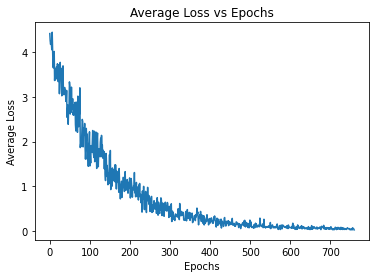

In [ ]:

#Training for Resnet18 
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt


# loss function.
loss_func = nn.CrossEntropyLoss()

# optimizer.
#opt = optim.Adam(net.parameters(), lr=0.001)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

avg_losses = []   
epochs = 10      
print_freq = 1  

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # progress bar
    for i, data in enumerate(pbar):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        pbar.set_postfix({"Avg Loss": f"{running_loss / (i+1):.3f}"}) # Update progress bar
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

# Plot the average loss graph.
plt.figure()
plt.plot(avg_losses)
plt.title('Average Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score

#@title Evaluation

y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
        y_true += labels.tolist()

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy of the network on the test images: %d %%' % (100 * accuracy))

Accuracy of the network on the test images: 88 %


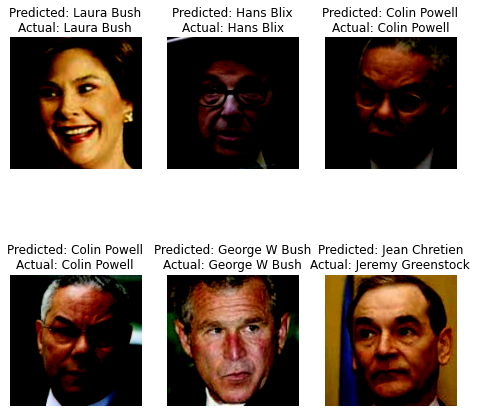

In [ ]:
target_names = lfw_people.target_names
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
net.eval() # eval mode
with torch.no_grad(): # no need 
    for i in range(6):
        ax = axs[i // 3, i % 3]
        img = test_X[i].unsqueeze(0).to(device) # get the image and move
        label = test_y[i]
        output = net(img)
        pred = torch.argmax(output, dim=1) # get predicted label
        ax.imshow(test_X[i].permute(1, 2, 0))
        ax.set_title(f"Predicted: {target_names[pred.item()]}\nActual: {target_names[label.item()]}")
        ax.axis('off')
plt.show()



In [ ]:
from torchsummary import summary

#summarizing the architecture
net = Net()
net.to(device)

summary(net, input_size=(3, 154, 154))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 154, 154]             448
         MaxPool2d-2           [-1, 16, 77, 77]               0
            Conv2d-3           [-1, 32, 77, 77]           4,640
         MaxPool2d-4           [-1, 32, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          18,496
         MaxPool2d-6           [-1, 64, 19, 19]               0
            Linear-7                  [-1, 512]      11,829,760
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 62]          31,806
Total params: 11,885,150
Trainable params: 11,885,150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.27
Forward/backward pass size (MB): 6.31
Params size (MB): 45.34
Estimated Total Size (MB): 51.92
-----------------------------------